# 라이브러리 호출

In [ ]:
# sudo apt-get install -y fonts-nanum*

In [1]:
import os
import sys
import re
import pandas as pd
import numpy as np
import torch
from collections import Counter
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModelForCausalLM
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from collections import Counter
import re

pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
pd.set_option("display.max_colwidth", None)
pd.set_option("display.width", None)

# 한글 폰트 설정

# plt.rcParams['font.family'] = 'AppleGothic' # Mac
plt.rcParams['font.family'] = 'NanumGothic' # Windows
plt.rcParams['axes.unicode_minus'] = False # 마이너스 폰트 깨짐 방지

# 데이터 불러오기

In [2]:
train_raw = pd.read_csv("../data/train.csv")
train_raw.head()

,fname,dialogue,summary,topic
0,train_0,"#Person1#: 안녕하세요, Mr. Smith. 저는 Dr. Hawkins입니다. 오늘 무슨 일로 오셨어요? \n#Person2#: 건강검진을 받으려고 왔어요. \n#Person1#: 네, 5년 동안 검진을 안 받으셨네요. 매년 한 번씩 받으셔야 해요. \n#Person2#: 알죠. 특별히 아픈 데가 없으면 굳이 갈 필요가 없다고 생각했어요. \n#Person1#: 음, 심각한 질병을 피하려면 미리 발견하는 게 제일 좋거든요. 본인을 위해서라도 매년 한 번은 오세요. \n#Person2#: 알겠습니다. \n#Person1#: 여기 좀 볼까요. 눈과 귀는 괜찮으시네요. 깊게 숨 한 번 쉬어보세요. Mr. Smith, 담배 피우세요? \n#Person2#: 네. \n#Person1#: 담배가 폐암하고 심장병의 주된 원인인 거 아시죠? 끊으셔야 해요. \n#Person2#: 수백 번 시도했는데, 도저히 습관이 안 끊어져요. \n#Person1#: 음, 도움 될만한 수업과 약물들이 있습니다. 가시기 전에 더 정보를 드릴게요. \n#Person2#: 네, 고맙습니다, 의사 선생님.","Mr. Smith는 Dr. Hawkins에게 건강검진을 받으러 와서, 매년 검진 필요성을 안내받고 흡연 습관 개선을 위한 도움을 제안받았습니다.",건강검진
1,train_1,"#Person1#: 안녕하세요, Mrs. Parker. 잘 지내셨나요?\n#Person2#: 안녕하세요, Dr. Peters. 잘 지내고 있어요. Ricky랑 저희 둘 다 백신 맞으러 왔어요.\n#Person1#: 알겠습니다. 백신 기록을 보니 Ricky는 소아마비, 파상풍, 그리고 B형 간염 예방접종을 받았네요. 지금 14개월이라 A형 간염, 수두, 홍역 예방접종을 맞아야 해요.\n#Person2#: 풍진과 유행성이하선염은요?\n#Person1#: 지금은 이 정도만 맞고, 몇 주 후에 나머지를 할 수 있어요.\n#Person2#: 좋아요. 그리고 저도 파상풍 부스터가 필요할 것 같아요. 마지막으로 맞은 지 아마 15년은 된 것 같아요!\n#Person1#: 기록을 확인해서 간호사에게 부스터도 맞출 수 있도록 할게요. 이제 Ricky 팔 꽉 잡아주세요, 좀 따끔할 수 있어요.","Mrs. Parker가 Ricky와 함께 백신 접종을 위해 방문하였고, Dr. Peters는 Ricky에게 적절한 백신을 접종하도록 안내합니다.",백신 접종
2,train_2,"#Person1#: 저기요, 열쇠 세트 본 적 있어요?\n#Person2#: 어떤 종류의 열쇠요?\n#Person1#: 열쇠 다섯 개랑 작은 발 장식이 달려 있어요.\n#Person2#: 아, 안타깝네요! 못 봤어요.\n#Person1#: 그럼, 같이 좀 찾아주실 수 있어요? 여긴 처음이라서요.\n#Person2#: 물론이죠. 도와드릴게요.\n#Person1#: 정말 친절하시네요.\n#Person2#: 별거 아니에요. 이봐요, 찾았어요.\n#Person1#: 아, 감사합니다! 어떻게 감사해야 할지 모르겠네요.\n#Person2#: 천만에요.",#Person1#은 열쇠 세트를 잃어버리고 #Person2#에게 찾는 것을 도와달라고 요청합니다.,열쇠 분실
3,train_3,"#Person1#: 너 여자친구 있는 거 왜 말 안 했어?\n#Person2#: 미안해, 네가 알고 있는 줄 알았어.\n#Person1#: 그런데 사랑하는 사람 있다고 말했어야지.\n#Person2#: 내가 안 했었나?\n#Person1#: 안 했잖아.\n#Person2#: 이제 말하잖아.\n#Person1#: 맞아, 그런데 이전에 말할 수도 있었잖아.\n#Person2#: 네가 관심 없을 줄 알았어.\n#Person1#: 진심이야? 결혼할 거라는 말도 안 하다니 참.\n#Person2#: 미안해, 별로 중요하지 않다고 생각했어.\n#Person1#: 아, 남자들 다 똑같아!",#Person1#은 #Person2#가 여자친구가 있고 결혼할 예정이라는 사실을 말하지 않아서 화가 났습니다.,여자친구와의 결혼
4,train_4,"#Person1#: 안녕, 오늘 너무 멋져 보이네요. 저랑 춤 한 곡 추실래요?\n#Person2#: 고맙네요! 그런데 저는 춤 잘 못 춰요...\n#Person1#: 괜찮아요. 제가 멋진 춤 동작 알려드릴게요. 제 이름은 Malik이에요.\n#Person2#: 만나서 반가워요. 저는 Wen이고, 이 친구는 Nikki예요.\n#Person1#: 기분 어때요? 친구랑 같이 춤춰도 될까요?\n#Person2#: 괜찮아요, 대신 제 발을 밟아도 괜찮으시다면요.\n#Person1#: 알겠어요. 좋아요! 가요!","Malik은 Wen과 Nikki에게 춤을 제안하고, Wen은 발을 밟는 것을 감수하면 괜찮다고 응답합니다.",춤 제안


In [3]:
dev_raw = pd.read_csv("../data/dev.csv")
dev_raw.head()

,fname,dialogue,summary,topic
0,dev_0,"#Person1#: 안녕하세요, 오늘 기분이 어떠세요?\n#Person2#: 요즘 숨쉬기가 힘들어요.\n#Person1#: 최근에 감기에 걸렸나요?\n#Person2#: 아니요, 감기는 안 걸렸어요. 숨쉴 때 가슴이 답답해요.\n#Person1#: 혹시 알고 있는 알레르기 있으세요?\n#Person2#: 아니요, 특별히 알고 있는 알레르기는 없어요.\n#Person1#: 이게 항상 그런가요, 아니면 주로 활동할 때 그런가요?\n#Person2#: 운동할 때 특히 많이 그래요.\n#Person1#: 천식 검사를 위해 폐 전문의에게 가보시는 게 좋겠어요.\n#Person2#: 도와주셔서 감사합니다, 의사 선생님.","#Person2#는 숨쉬기 어려워합니다. 의사는 #Person2#에게 증상을 확인하고, 천식 검사를 위해 폐 전문의에게 가볼 것을 권합니다.",의사 상담
1,dev_1,"#Person1#: 야 Jimmy, 오늘 좀 이따 운동하러 가자.\n#Person2#: 그래, 몇 시에 갈래?\n#Person1#: 3시 30분 어때?\n#Person2#: 좋아. 오늘은 다리랑 팔 운동하는 날이야.\n#Person1#: 근데 나 아까 농구해서 다리가 좀 아파. 오늘은 팔이랑 복근 운동하자.\n#Person2#: 나 주간 일정이 있어. 너 때문에 다 엉망이야.\n#Person1#: 아, 두 날짜만 바꾸면 되잖아. 다리는 금요일에 하면 돼.\n#Person2#: 알았어. 그럼 3시 30분에 체육관에서 보자.",#Person1#는 Jimmy를 운동하러 초대하고 팔과 복근 운동을 하도록 설득합니다.,운동 계획
2,dev_2,"#Person1#: 나 진짜 건강에 안 좋은 음식 좀 그만 먹어야겠어. \n#Person2#: 맞아, 무슨 말인지 알아. 나도 요즘 건강하게 먹으려고 하거든. \n#Person1#: 요즘은 뭐 먹어? \n#Person2#: 주로 과일이랑 채소, 닭고기 먹지. \n#Person1#: 그게 다야? \n#Person2#: 거의 그렇지 뭐. \n#Person1#: 왜 다른 건 안 먹어? \n#Person2#: 음, 과일이랑 채소는 진짜 건강에 좋잖아. \n#Person1#: 그럼 닭고기는? \n#Person2#: 구워 먹으면 정말 건강에 좋아. \n#Person1#: 그래, 그게 훨씬 건강해 보이네.","#Person1#은 건강에 안 좋은 음식을 그만 먹기로 결심하고, #Person2#는 자신의 건강한 식단을 #Person1#에게 공유합니다.",건강한 식단
3,dev_3,"#Person1#: 너 UFO 믿어?\n#Person2#: 당연하지, 있는 거 아냐.\n#Person1#: 근데 나는 못 봤어.\n#Person2#: 바보야? 그게 UFO라서 아무나 볼 수 있는 게 아니야.\n#Person1#: 너는 볼 수 있다는 거야?\n#Person2#: 맞아. 꿈에서 볼 수 있어.\n#Person1#: 지구로 오는 거야?\n#Person2#: 아니야. 자기네 우주에서 외계인을 지구로 보내는 게 임무야.\n#Person1#: 우주에서 온 외계인? 말해봤어? 어떻게 생겼어?\n#Person2#: 아이고, 아이고, 하나씩 물어봐! 로봇같이 생겼는데 말할 수 있어. 인간이랑 친구가 되는 게 임무야.\n#Person1#: 그러면 너 걔들이랑 얘기해? 무슨 언어로?\n#Person2#: 당연히 영어로 하지, 걔네도 화성에서 영어 배워.\n#Person1#: 와, 대단하다!","#Person2#는 UFO를 믿고 꿈에서 볼 수 있다고 한다. #Person1#은 #Person2#가 꿈에서 본 UFO와 외계인에 대해 물어보고, #Person2#의 꿈이 대단하다고 생각한다.",UFO와 외계인
4,dev_4,"#Person1#: 오늘 학교 갔어?\n#Person2#: 당연히 갔지. 너는?\n#Person1#: 가기 싫어서 안 갔어.\n#Person2#: 아쉽네. 근데 영화 본 지는 얼마 안 됐어?\n#Person1#: 화제를 바꾸네.\n#Person2#: 진지하게 묻는 거야, 본 적 있어?\n#Person1#: 아니, 안 봤어. 왜?\n#Person2#: 이번 주말에 정말 영화 보러 가고 싶거든.\n#Person1#: 그럼 가.\n#Person2#: 혼자 가기는 좀 싫어.\n#Person1#: 아무튼, 내일은 학교 갈 거야?\n#Person2#: 아니, 내일은 영화 보러 갈까 생각 중이야.","#Person1#은 오늘 학교에 가지 않았고, #Person2#는 내일 학교 대신 영화관에 가고 싶어합니다.",학교와 주말 계획


In [4]:
test_raw = pd.read_csv("../data/test.csv")
test_raw.head()

,fname,dialogue
0,test_0,"#Person1#: Ms. Dawson, 받아쓰기 좀 부탁드려야겠어요. \n#Person2#: 네, 말씀하세요... \n#Person1#: 이걸 오늘 오후까지 모든 직원들에게 사내 메모로 보내야 해요. 준비됐나요? \n#Person2#: 네, 말씀하세요. \n#Person1#: 모든 직원에게 알립니다... 즉시 발효되어 모든 사내 통신은 이메일과 공식 메모로만 제한됩니다. 근무 시간 동안 즉시 메시지 프로그램 사용은 금지됩니다. \n#Person2#: 이 정책이 사내 통신에만 적용되나요, 아니면 외부 통신에도 해당되나요? \n#Person1#: 이는 모든 통신에 적용됩니다. 사무실 내 직원 간 통신 뿐만 아니라 외부 통신도 해당됩니다. \n#Person2#: 하지만 많은 직원들이 고객과 소통하려고 즉시 메시지를 사용합니다. \n#Person1#: 통신 방법을 바꿔야 할 것입니다. 이 사무실에서는 즉시 메시지를 사용하는 것을 원하지 않습니다. 너무 많은 시간이 낭비됩니다! 이제 계속해서 메모를 작성해 주세요. 어디까지 했죠? \n#Person2#: 내외부 통신에 적용됩니다. \n#Person1#: 네. 즉시 메시지를 계속 사용하면 경고 후 시정 조치가 이루어지며, 두 번째 위반 시 해고될 수 있습니다. 이번 정책에 관한 질문은 부서장에게 문의하세요. \n#Person2#: 그게 다인가요? \n#Person1#: 네. 오늘 오후 4시까지 이 메모를 작성하고 배포해주세요."
1,test_1,"#Person1#: 드디어 왔네! 뭐가 이렇게 오래 걸렸어?\n#Person2#: 차가 또 막혔어. Carrefour 교차로 근처에서 교통체증이 엄청 심했거든.\n#Person1#: 거긴 출퇴근 시간에 항상 혼잡하잖아. 집에 갈 때 다른 길 좀 찾아보는 게 어때?\n#Person2#: 솔직히 피할 수 있을 것 같진 않아.\n#Person1#: 대중교통으로 출퇴근하는 게 더 나을 수도 있겠다.\n#Person2#: 생각해봐야 할 것 같아. 대중교통이 꽤 괜찮더라고.\n#Person1#: 환경에도 더 좋을 거야.\n#Person2#: 알아. 내 차가 이 도시의 오염 문제를 얼마나 악화시키는지 미안하게 생각해.\n#Person1#: 지하철 타고 다니는 게 운전하는 것보다 스트레스도 덜할 거야.\n#Person2#: 문제는 차가 줄 수 있는 자유를 정말 그리워할 것 같단 말이지.\n#Person1#: 글쎄, 날씨 좋으면 자전거로 출근해봐. 차만큼 자유로울 거야.\n#Person2#: 맞아. 운동도 될 것 같아!\n#Person1#: 그럼 출근할 때 차 안 타기로 했어?\n#Person2#: 응, 나나 환경에 좋지 않잖아."
2,test_2,"#Person1#: Kate, 여기서 일어난 일을 믿기 힘들 거야.\n#Person2#: 무슨 일이야?\n#Person1#: Masha랑 Hero가 이혼한대.\n#Person2#: 설마, 무슨 일 있었던 거야?\n#Person1#: 글쎄, 자세히는 모르겠는데 두 달 동안 별거 중이더니 결국 이혼 신청을 했대.\n#Person2#: 정말 놀랍네. 난 둘이 정말 잘 어울리는 커플이라 생각했어. 아이들은 어떻게 되는 거야? 누가 양육권을 가지지?\n#Person1#: Masha가 양육권을 가지기로 했대. 모든 게 조용하고 원만하게 진행되고 있고, 집이나 주식 문제는 깔끔하게 해결됐다고 하더라.\n#Person2#: 보통 듣는 사건들이랑 달리 잘 진행되네. 그래도 믿기지가 않네, Masha랑 Hero, 완벽한 커플이었는데. 언제쯤 이혼이 확정될까?\n#Person1#: 아마도 새해 초쯤이겠지."
3,test_3,"#Person1#: 생일 축하해, 이거 너를 위한 선물이야, Brian.\n#Person2#: 기억해줘서 정말 고마워. 들어와서 파티를 즐겨. 모두들 와 있어서 정말 좋은 시간이 될 거야.\n#Person1#: Brian, 너랑 춤춰도 될까?\n#Person2#: 그래, 좋아.\n#Person1#: 정말 멋진 파티야.\n#Person2#: 응, 너는 항상 모두에게 인기가 많아. 그리고 오늘 정말 예뻐 보여.\n#Person1#: 고마워, 그렇게 말해줘서 다정하네. 목걸이가 드레스랑 잘 어울려서 나도 그렇게 느껴져.\n#Person2#: 정말 멋있어 보여, 너 정말 빛나고 있어.\n#Person1#: 고마워, 정말 멋진 파티야. 네 생일을 축하하기 위해 같이 한 잔 해야겠다."
4,test_4,"#Person1#: 이 올림픽 공원 정말 크다! \n#Person2#: 맞아. 지금 우리는 이 공원의 중심인 올림픽 스타디움에 있어. \n#Person1#: 멋지다! 언제 완공될까? \n#Person2#: 전체 스타디움은 이번 6월에 완공될 예정이야. \n#Person1#: 좌석이 얼마나 되지? \n#Person2#: 음, 총 5000석이 있어. \n#Person1#: 이렇게 클 줄은 몰랐어! \n#Person2#: 그치? 저기 봐, 저게 육상 트랙이야. 그리고 저쪽이 점프 구간이야. \n#Person1#: 아... 알겠어. 이봐, 여기 표지판에 봐, 등산 금지라고 하네. \n#Person2#: 외국인 방문객들을 위해 영어 번역된 표지판도 많이 붙였어."


# 대화문, 요약문, 주제 분석

In [20]:
def analyze_dialogues(df, dataset_name=""):
    """대화문의 특성 분석"""
    dialogues = df['dialogue'].values
    
    # 1. 발화 수 분석
    utterance_counts = []
    dialogue_lengths = []
    
    # 2. 화자 수 분석
    speaker_counts = []
    speaker_types = []
    
    for d in dialogues:
        # 발화 수
        utterances = [u for u in d.split('\n') if u.strip() and '#Person' in u]
        utterance_counts.append(len(utterances))
        
        # 대화 길이
        dialogue_lengths.append(len(d))
        
        # 화자 수
        speakers = set(re.findall(r'#Person\d+#', d))
        speaker_counts.append(len(speakers))
        
        # 화자 종류
        speaker_types.extend(speakers)
    
    print("=== 대화 길이 분석 ===")
    print(f"평균 길이: {np.mean(dialogue_lengths):.0f}자")
    print(f"중앙값: {np.median(dialogue_lengths):.0f}자")
    print(f"최소/최대: {min(dialogue_lengths)}/{max(dialogue_lengths)}자")
    
    print("\n=== 발화 수 분석 ===")
    print(f"평균 발화 수: {np.mean(utterance_counts):.1f}개")
    print(f"중앙값: {np.median(utterance_counts):.0f}개")
    print(f"최소/최대: {min(utterance_counts)}/{max(utterance_counts)}개")
    
    print("\n=== 화자 수 분석 ===")
    print(f"평균 화자 수: {np.mean(speaker_counts):.2f}명")
    speaker_counter = Counter(speaker_counts)
    for count, freq in sorted(speaker_counter.items()):
        print(f"{count}명 대화: {freq}개 ({freq/len(dialogues)*100:.1f}%)")
    
    print("\n=== 등장 화자 종류 ===")
    speaker_type_counter = Counter(speaker_types)
    for speaker, freq in sorted(speaker_type_counter.items()):
        print(f"{speaker}: {freq}회 등장")
    
    # 대화 샘플
    print("\n=== 대화문 샘플 (짧은 것 1개) ===")
    shortest_idx = np.argmin(dialogue_lengths)
    print(f"[길이: {dialogue_lengths[shortest_idx]}자, 발화 수: {utterance_counts[shortest_idx]}개]")
    print(dialogues[shortest_idx][:500] + "..." if len(dialogues[shortest_idx]) > 500 else dialogues[shortest_idx])
    
    utterance_counts = []
    dialogue_lengths = []
    speaker_counts = []
    speaker_types = []
    
    for d in dialogues:
        utterances = [u for u in d.split('\n') if u.strip() and '#Person' in u]
        utterance_counts.append(len(utterances))
        dialogue_lengths.append(len(d))
        speakers = set(re.findall(r'#Person\d+#', d))
        speaker_counts.append(len(speakers))
        speaker_types.extend(speakers)
    
    # 분석결과 출력 시작 
    print(f"\n{'='*50}")
    print(f"{dataset_name} 대화문 분석")
    
    # 플롯
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    fig.suptitle(f'[{dataset_name}] Dialogue Analysis Plots', fontsize=16)

    # 1. 대화 길이 분포
    sns.histplot(dialogue_lengths, kde=True, ax=axes[0], bins=30)
    axes[0].set_title('Dialogue Length Distribution')
    axes[0].set_xlabel('Character Count')

    # 2. 발화 수 분포
    sns.histplot(utterance_counts, kde=True, ax=axes[1], discrete=True)
    axes[1].set_title('Utterance Count Distribution')
    axes[1].set_xlabel('Number of Utterances')

    # 3. 화자 수 분포
    sns.countplot(x=speaker_counts, ax=axes[2])
    axes[2].set_title('Speaker Count Distribution')
    axes[2].set_xlabel('Number of Speakers')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

    return {
        'utterance_counts': utterance_counts,
        'dialogue_lengths': dialogue_lengths,
        'speaker_counts': speaker_counts
    }

In [21]:
def analyze_summaries(df, dataset_name=""):
    """요약문의 특성 분석"""
    summaries = df['summary'].values
    
    # 1. 길이 분석
    lengths = [len(s) for s in summaries]
    
    # 2. 화자 패턴 분석
    person_patterns = []
    for s in summaries:
        persons = re.findall(r'#Person\d+#', s)
        person_patterns.append(len(persons))
    
    # 3. 문장 구조 분석
    sentence_starts = []
    for s in summaries:
        if s.startswith('#Person'):
            sentence_starts.append('person_first')
        else:
            sentence_starts.append('other')
    
    # 4. 특수 패턴 분석
    has_quotes = sum(1 for s in summaries if '"' in s or "'" in s)
    has_numbers = sum(1 for s in summaries if any(c.isdigit() for c in s))
    
    lengths = [len(s) for s in summaries]
    person_patterns = [len(re.findall(r'#Person\d+#', s)) for s in summaries]
    sentence_starts = ['person_first' if s.startswith('#Person') else 'other' for s in summaries]

    # 분석결과 출력 시작 
    print(f"{'='*50}")
    print(f"{dataset_name} 요약문 분석")

    print("=== 길이 분석 ===")
    print(f"총 샘플 수: {len(summaries)}")
    print(f"평균 길이: {np.mean(lengths):.1f}자")
    print(f"중앙값: {np.median(lengths):.1f}자")
    print(f"표준편차: {np.std(lengths):.1f}자")
    print(f"최소/최대: {min(lengths)}/{max(lengths)}자")
    print(f"사분위수: Q1={np.percentile(lengths, 25):.0f}, Q3={np.percentile(lengths, 75):.0f}")
    
    print("\n=== 화자 언급 횟수 ===")
    person_counter = Counter(person_patterns)
    for count, freq in sorted(person_counter.items()):
        print(f"화자 {count}명 언급: {freq}개 ({freq/len(summaries)*100:.1f}%)")
    
    print("\n=== 문장 시작 패턴 ===")
    start_counter = Counter(sentence_starts)
    for pattern, freq in start_counter.items():
        print(f"{pattern}: {freq}개 ({freq/len(summaries)*100:.1f}%)")
    
    print("\n=== 특수 패턴 ===")
    print(f"따옴표 포함: {has_quotes}개 ({has_quotes/len(summaries)*100:.1f}%)")
    print(f"숫자 포함: {has_numbers}개 ({has_numbers/len(summaries)*100:.1f}%)")
    
    # 샘플 출력
    print("\n=== 요약문 샘플 (무작위 5개) ===")
    samples = np.random.choice(len(summaries), min(5, len(summaries)), replace=False)
    for i, idx in enumerate(samples, 1):
        print(f"\n[샘플 {i}] (길이: {len(summaries[idx])}자)")
        print(summaries[idx])

    # 플롯
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    fig.suptitle(f'[{dataset_name}] Summary Analysis Plots', fontsize=16)

    # 1. 요약문 길이 분포
    sns.histplot(lengths, kde=True, ax=axes[0], bins=30)
    axes[0].set_title('Summary Length Distribution')
    axes[0].set_xlabel('Character Count')

    # 2. 화자 언급 횟수 분포
    sns.countplot(x=person_patterns, ax=axes[1])
    axes[1].set_title('Speaker Mention Count')
    axes[1].set_xlabel('Number of Speakers')

    # 3. 문장 시작 패턴 비율
    start_counts = Counter(sentence_starts)
    axes[2].pie(start_counts.values(), labels=start_counts.keys(), autopct='%1.1f%%', startangle=90)
    axes[2].set_title('Sentence Start Pattern')
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

    return {
        'lengths': lengths,
        'person_patterns': person_patterns,
        'avg_length': np.mean(lengths),
        'median_length': np.median(lengths)
    }

In [22]:
def analyze_topics(df, dataset_name="", top_n=50):
    """
    토픽 분석 및 시각화.
    top_n: 상위 n개 토픽을 지정. None일 경우 모든 토픽을 표시.
    """
    if 'topic' not in df.columns:
        print(f"\n{dataset_name}에는 topic 정보가 없습니다.")
        return
    
    topics = df['topic'].values
    topic_counter = Counter(topics)

    print(f"\n{'='*50}")
    print(f"{dataset_name} 토픽 분석")
    
    # 1. top_n 값에 따라 most_common 호출
    # top_n이 None이면 모든 항목을, 숫자이면 해당 개수만큼 가져옴
    top_topics = topic_counter.most_common(top_n)
    
    # most_common은 (topic, freq) 튜플의 리스트를 반환하므로 분리
    topics_labels = [topic[0] for topic in top_topics]
    topics_values = [topic[1] for topic in top_topics]
    
    # 2. top_n 값에 따라 그래프 제목과 크기 동적 설정
    if top_n is None:
        title = f'[{dataset_name}] All Topics Distribution'
        fig_height = max(8, len(topics_labels) * 0.3) 
    else:
        title = f'[{dataset_name}] Top {top_n} Topics'
        fig_height = 8

    plt.figure(figsize=(10, fig_height))
    sns.barplot(x=topics_values, y=topics_labels, orient='h')
    plt.title(title, fontsize=16)
    plt.xlabel('Frequency')
    plt.ylabel('Topic')
    plt.tight_layout()
    plt.show()
    
    return topic_counter

In [23]:
def compare_train_dev(train_stats, dev_stats):
    """Train과 Dev 데이터 비교"""
    print(f"\n{'='*50}")
    print("Train vs Dev 비교")

    metrics = ['Avg Summary Length', 'Avg Utterance Count']
    train_values = [
        train_stats['summary']['avg_length'],
        np.mean(train_stats['dialogue']['utterance_counts'])
    ]
    dev_values = [
        dev_stats['summary']['avg_length'],
        np.mean(dev_stats['dialogue']['utterance_counts'])
    ]
    
    print("=== 요약문 길이 비교 ===")
    print(f"Train 평균: {train_stats['summary']['avg_length']:.1f}자")
    print(f"Dev 평균: {dev_stats['summary']['avg_length']:.1f}자")
    print(f"차이: {abs(train_stats['summary']['avg_length'] - dev_stats['summary']['avg_length']):.1f}자")
    
    print("\n=== 대화 발화 수 비교 ===")
    print(f"Train 평균: {np.mean(train_stats['dialogue']['utterance_counts']):.1f}개")
    print(f"Dev 평균: {np.mean(dev_stats['dialogue']['utterance_counts']):.1f}개")

    x = np.arange(len(metrics))
    width = 0.35

    fig, ax = plt.subplots(figsize=(10, 6))
    rects1 = ax.bar(x - width/2, train_values, width, label='Train')
    rects2 = ax.bar(x + width/2, dev_values, width, label='Dev')

    ax.set_ylabel('Scores')
    ax.set_title('Train vs Dev Statistics Comparison')
    ax.set_xticks(x)
    ax.set_xticklabels(metrics)
    ax.legend()
    
    ax.bar_label(rects1, padding=3, fmt='%.1f')
    ax.bar_label(rects2, padding=3, fmt='%.1f')

    fig.tight_layout()
    plt.show()


                    데이터셋 기본 정보
Train: 12457개
Dev: 499개
Test: 499개
=== 대화 길이 분석 ===
평균 길이: 406자
중앙값: 369자
최소/최대: 84/2165자

=== 발화 수 분석 ===
평균 발화 수: 9.5개
중앙값: 9개
최소/최대: 1/59개

=== 화자 수 분석 ===
평균 화자 수: 2.01명
2명 대화: 12335개 (99.0%)
3명 대화: 107개 (0.9%)
4명 대화: 10개 (0.1%)
5명 대화: 3개 (0.0%)
6명 대화: 1개 (0.0%)
7명 대화: 1개 (0.0%)

=== 등장 화자 종류 ===
#Person1#: 12457회 등장
#Person2#: 12457회 등장
#Person3#: 122회 등장
#Person4#: 15회 등장
#Person5#: 5회 등장
#Person6#: 2회 등장
#Person7#: 1회 등장

=== 대화문 샘플 (짧은 것 1개) ===
[길이: 84자, 발화 수: 2개]
#Person1#: 또 인터넷이야? 언제 그만할 거야? 토크쇼 시간이라고. 
#Person2#: 잠깐만, 보고 있어. 엄마 생일 선물 제대로 고르려고.

TRAIN 대화문 분석


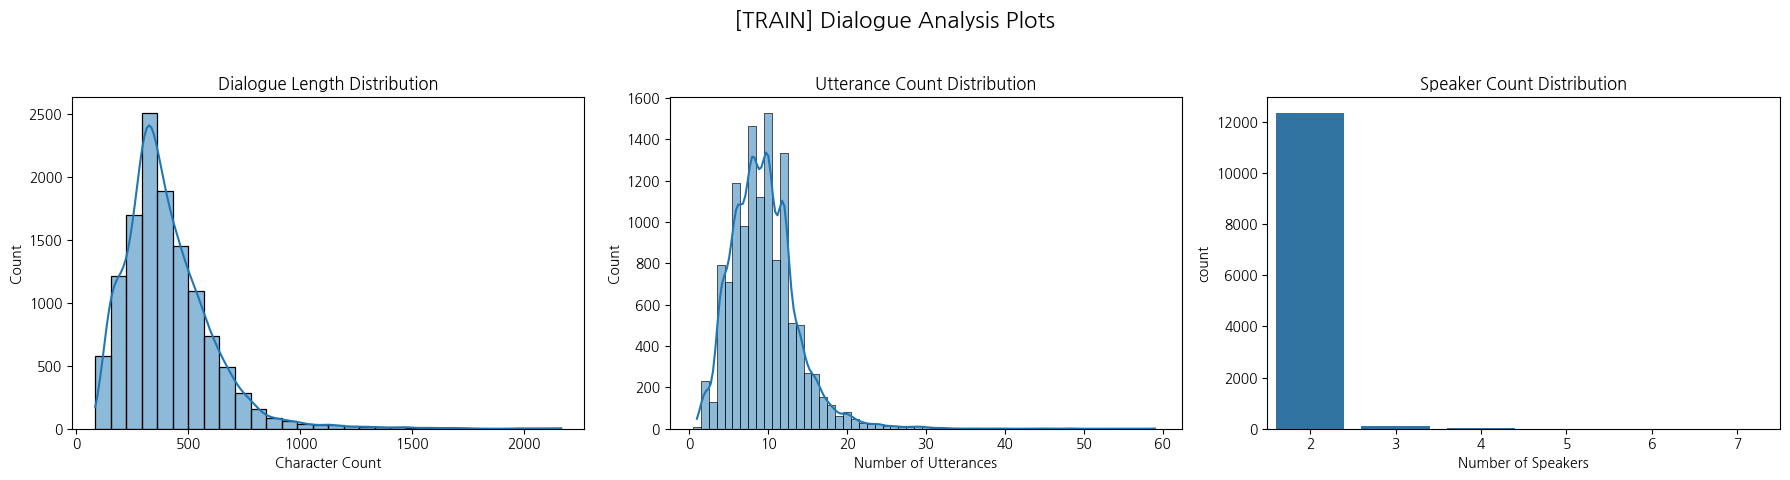

TRAIN 요약문 분석
=== 길이 분석 ===
총 샘플 수: 12457
평균 길이: 85.8자
중앙값: 80.0자
표준편차: 33.8자
최소/최대: 13/376자
사분위수: Q1=61, Q3=104

=== 화자 언급 횟수 ===
화자 0명 언급: 1760개 (14.1%)
화자 1명 언급: 1837개 (14.7%)
화자 2명 언급: 4772개 (38.3%)
화자 3명 언급: 2476개 (19.9%)
화자 4명 언급: 1117개 (9.0%)
화자 5명 언급: 338개 (2.7%)
화자 6명 언급: 114개 (0.9%)
화자 7명 언급: 30개 (0.2%)
화자 8명 언급: 10개 (0.1%)
화자 9명 언급: 3개 (0.0%)

=== 문장 시작 패턴 ===
other: 2872개 (23.1%)
person_first: 9585개 (76.9%)

=== 특수 패턴 ===
따옴표 포함: 193개 (1.5%)
숫자 포함: 10936개 (87.8%)

=== 요약문 샘플 (무작위 5개) ===

[샘플 1] (길이: 134자)
#Person1#이 Andy에게 Isabel 집의 재고 정리 세일에 같이 가자고 제안합니다. Andy는 옷을 갈아입은 후 가기로 하고, #Person1#은 Cindy가 이미 드레스를 샀음을 전합니다. #Person1#은 서두르자고 말합니다.

[샘플 2] (길이: 78자)
David는 여자친구가 뒷담화를 했다는 사실로 우울해하고 있습니다. #Person1#은 그를 위로하지만, David는 잊지 못하고 있습니다.

[샘플 3] (길이: 36자)
Jack은 오늘 날씨가 좋아 걸어서 출근하기로 했다고 설명합니다.

[샘플 4] (길이: 72자)
#Person1#은 아내를 위해 빨간 장미를 사려 하고, #Person2#는 장미를 더 오래 싱싱하게 유지하는 방법을 알려줍니다.

[샘플 5] (길이: 100자)
#Person1#은 방 3개짜리 아파트를 찾았지만 꼭대기 층에 있어서 망설였습니다. 화이트 씨는 2층에 있는 방 2개짜리 아파트를 추천했고, #

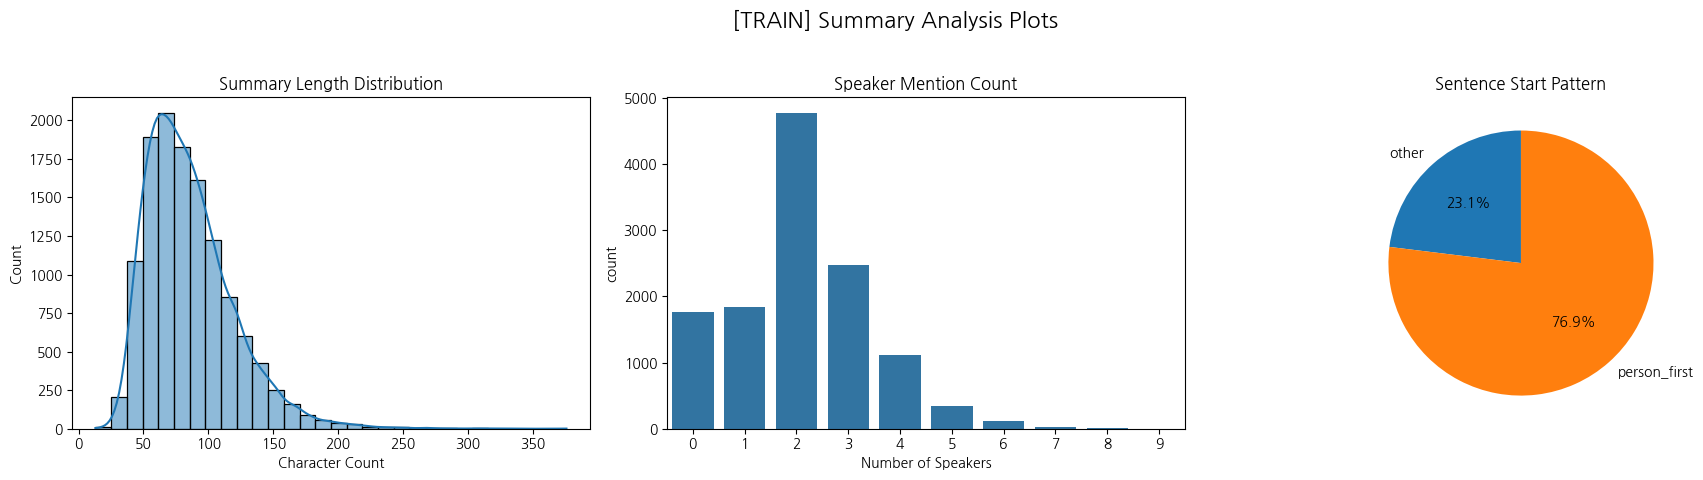


TRAIN 토픽 분석


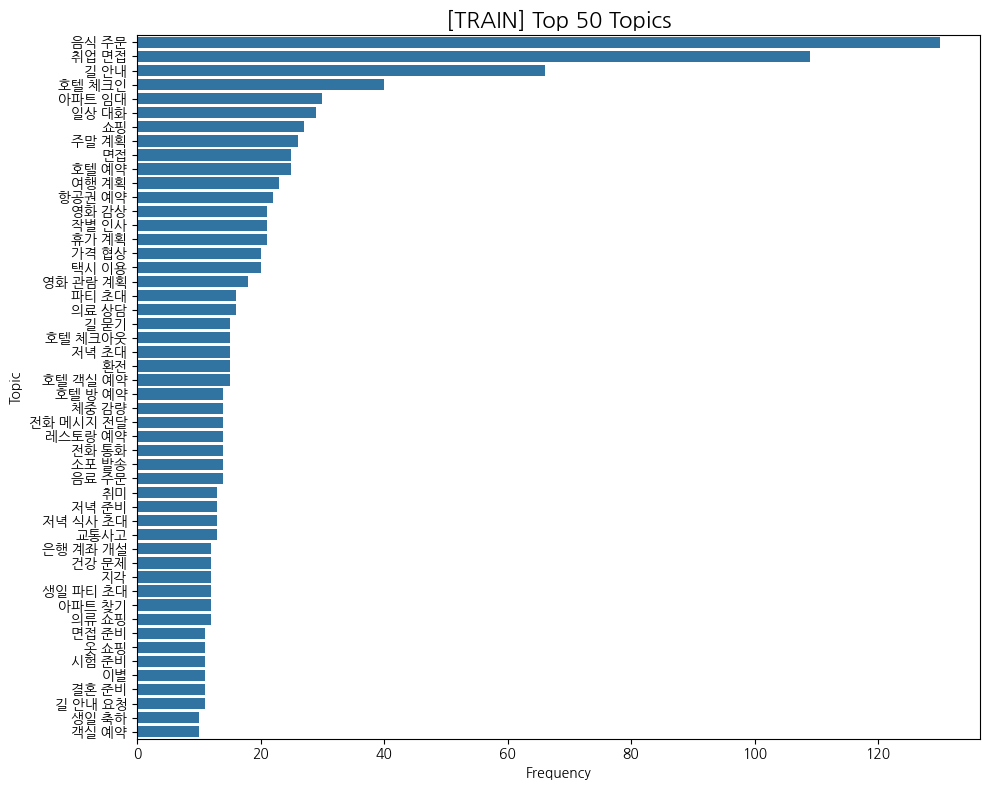

=== 대화 길이 분석 ===
평균 길이: 400자
중앙값: 367자
최소/최대: 114/1269자

=== 발화 수 분석 ===
평균 발화 수: 9.4개
중앙값: 9개
최소/최대: 2/29개

=== 화자 수 분석 ===
평균 화자 수: 2.01명
2명 대화: 494개 (99.0%)
3명 대화: 4개 (0.8%)
4명 대화: 1개 (0.2%)

=== 등장 화자 종류 ===
#Person1#: 499회 등장
#Person2#: 499회 등장
#Person3#: 5회 등장
#Person4#: 1회 등장

=== 대화문 샘플 (짧은 것 1개) ===
[길이: 114자, 발화 수: 2개]
#Person1#: 어제 얼음 위에서 넘어져서 손이 아직 아파. 혹시 뭔가 부러졌나 싶어. 
#Person2#: 내가 의사는 아니지만, 손 색이 멍든 것도 아니고 괜찮네. 며칠 쉬어보는 게 좋을 것 같아.

DEV 대화문 분석


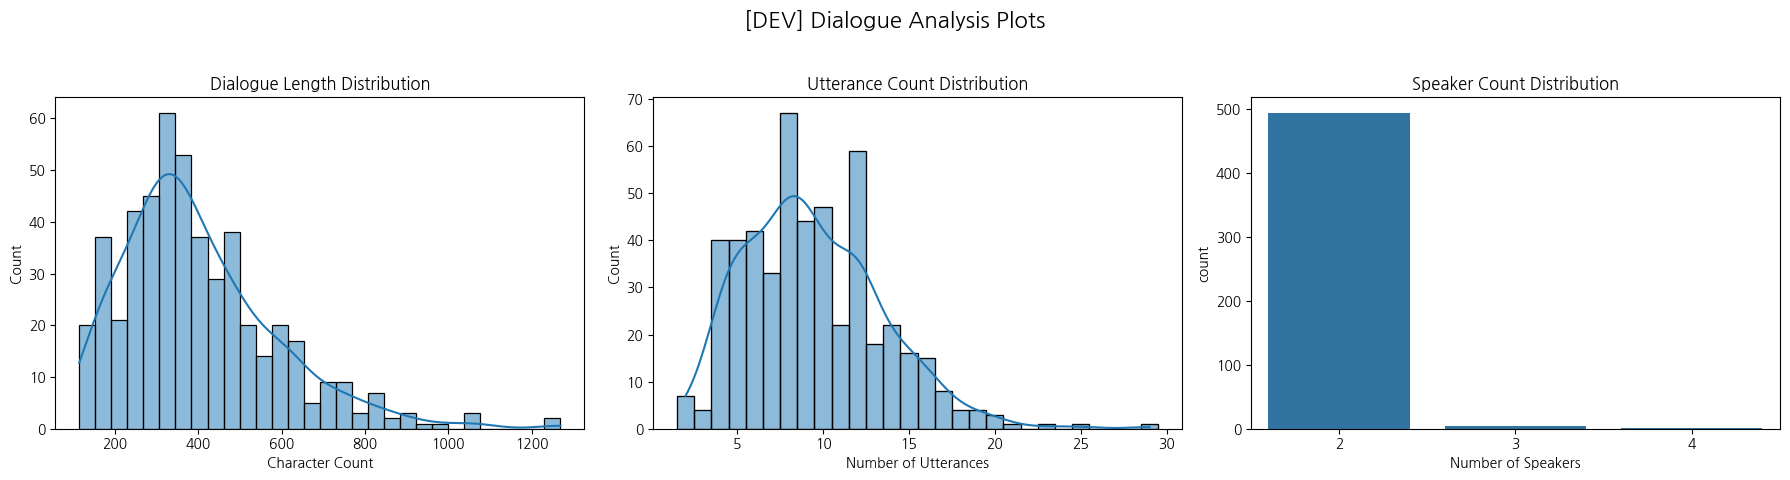

DEV 요약문 분석
=== 길이 분석 ===
총 샘플 수: 499
평균 길이: 81.2자
중앙값: 74.0자
표준편차: 32.5자
최소/최대: 29/283자
사분위수: Q1=58, Q3=96

=== 화자 언급 횟수 ===
화자 0명 언급: 59개 (11.8%)
화자 1명 언급: 64개 (12.8%)
화자 2명 언급: 226개 (45.3%)
화자 3명 언급: 86개 (17.2%)
화자 4명 언급: 41개 (8.2%)
화자 5명 언급: 15개 (3.0%)
화자 6명 언급: 7개 (1.4%)
화자 7명 언급: 1개 (0.2%)

=== 문장 시작 패턴 ===
person_first: 401개 (80.4%)
other: 98개 (19.6%)

=== 특수 패턴 ===
따옴표 포함: 5개 (1.0%)
숫자 포함: 452개 (90.6%)

=== 요약문 샘플 (무작위 5개) ===

[샘플 1] (길이: 84자)
#Person2#는 외국인과의 결혼 첫해가 어려웠다고 #Person1#에게 털어놓습니다. 또한 #Person2#는 자신의 아들에 대한 이야기도 합니다.

[샘플 2] (길이: 108자)
#Person1#은 #Person2#에게 17번가에 새로 생긴 바에 가자고 초대합니다. #Person2#는 자리, 입장료, 드레스 코드에 대해 묻고, #Person1#은 모든 질문에 답변합니다.

[샘플 3] (길이: 103자)
#Person1#은 #Person2#에게 카메라맨 직업에 대해 묻습니다. #Person2#는 이 직업을 선택한 이유, 수상 경력, 미래 계획, 직업의 가장 좋은 점에 대해 이야기합니다.

[샘플 4] (길이: 61자)
#Person2#는 #Person1#에게 물고기를 키우기 위해 수조, 바위, 수초 등을 준비하라고 조언합니다.

[샘플 5] (길이: 68자)
#Person2#가 중국 음식점에 방문하여, #Person1#이 #Person2#의 입맛에 맞춰 절강 요리를 추천했습니다.


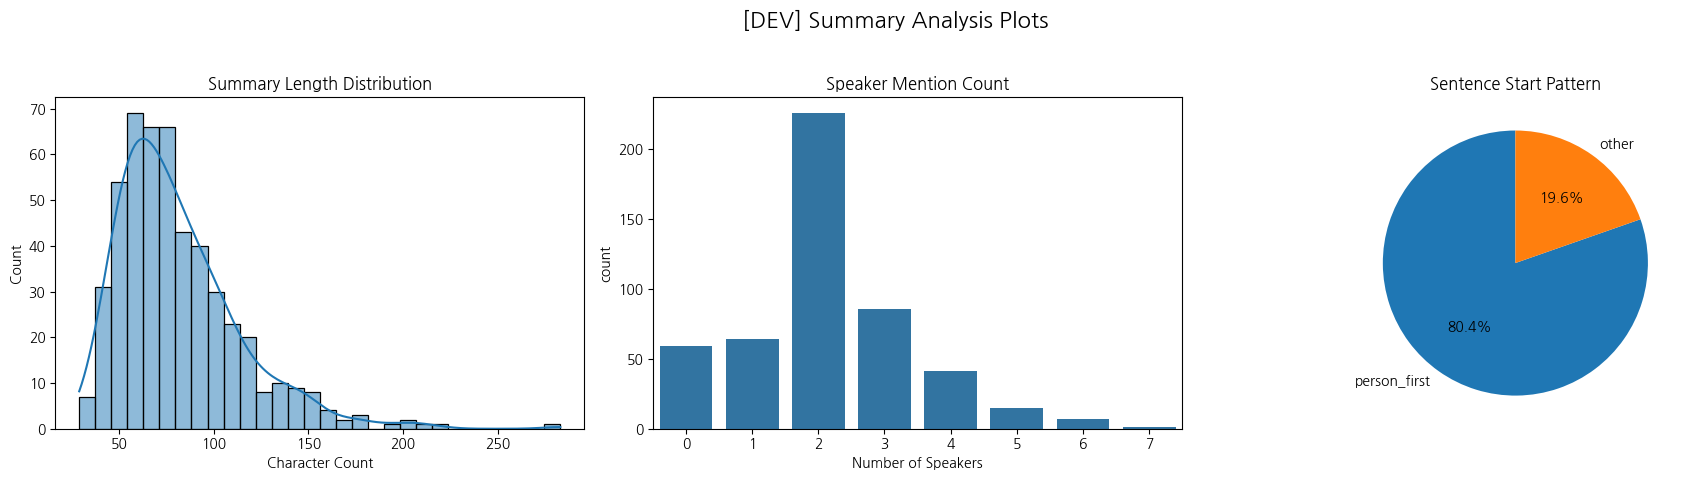


DEV 토픽 분석


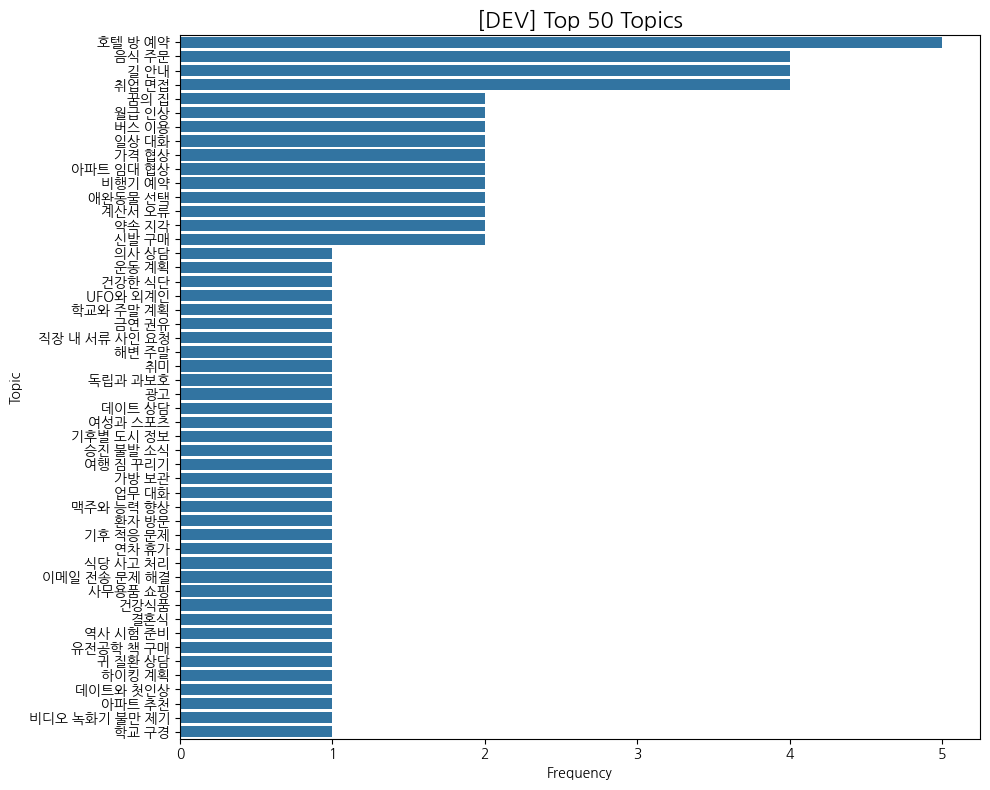

=== 대화 길이 분석 ===
평균 길이: 422자
중앙값: 386자
최소/최대: 111/2275자

=== 발화 수 분석 ===
평균 발화 수: 9.7개
중앙값: 9개
최소/최대: 1/63개

=== 화자 수 분석 ===
평균 화자 수: 2.01명
2명 대화: 495개 (99.2%)
3명 대화: 4개 (0.8%)

=== 등장 화자 종류 ===
#Person1#: 499회 등장
#Person2#: 499회 등장
#Person3#: 4회 등장

=== 대화문 샘플 (짧은 것 1개) ===
[길이: 111자, 발화 수: 2개]
#Person1#: 나 진짜 짜증나. 과제를 컴퓨터로 해야 하는데, 도서관에서 컴퓨터 쓰기가 너무 힘들어.
#Person2#: 네 기분 이해해. 나도 빨리 내 컴퓨터를 살 수 있는 날이 오면 좋겠어.

TEST 대화문 분석


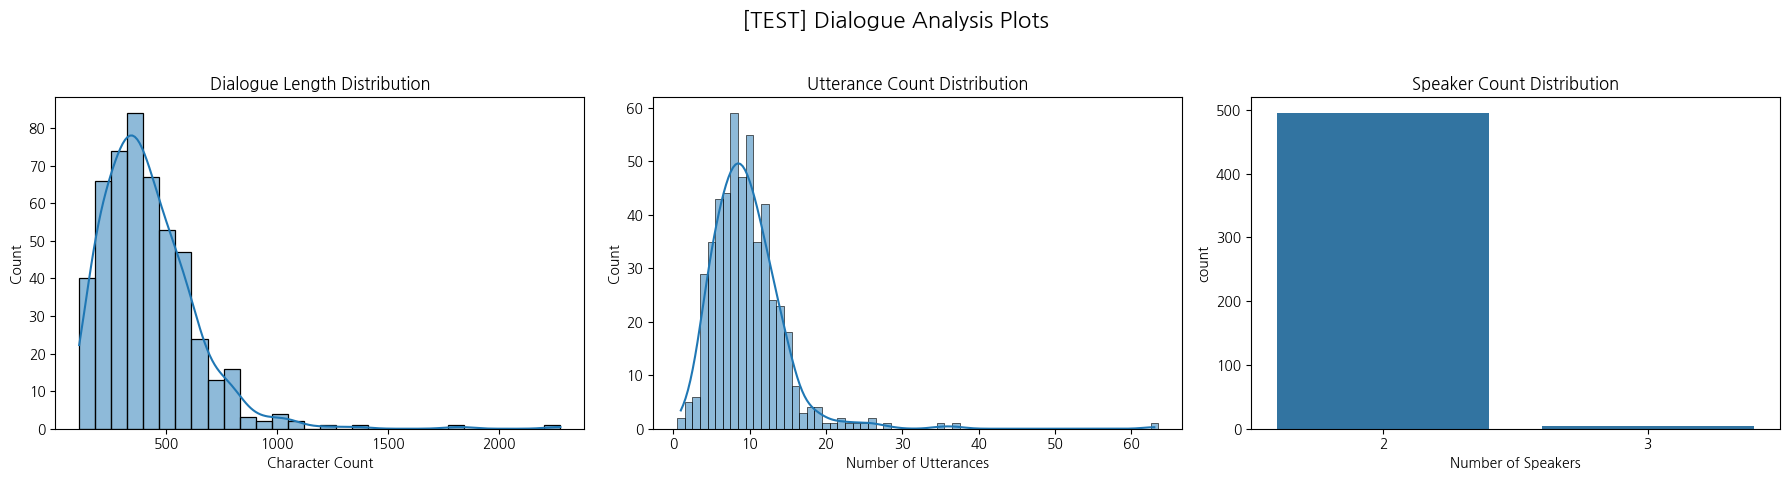


Train vs Dev 비교
=== 요약문 길이 비교 ===
Train 평균: 85.8자
Dev 평균: 81.2자
차이: 4.6자

=== 대화 발화 수 비교 ===
Train 평균: 9.5개
Dev 평균: 9.4개


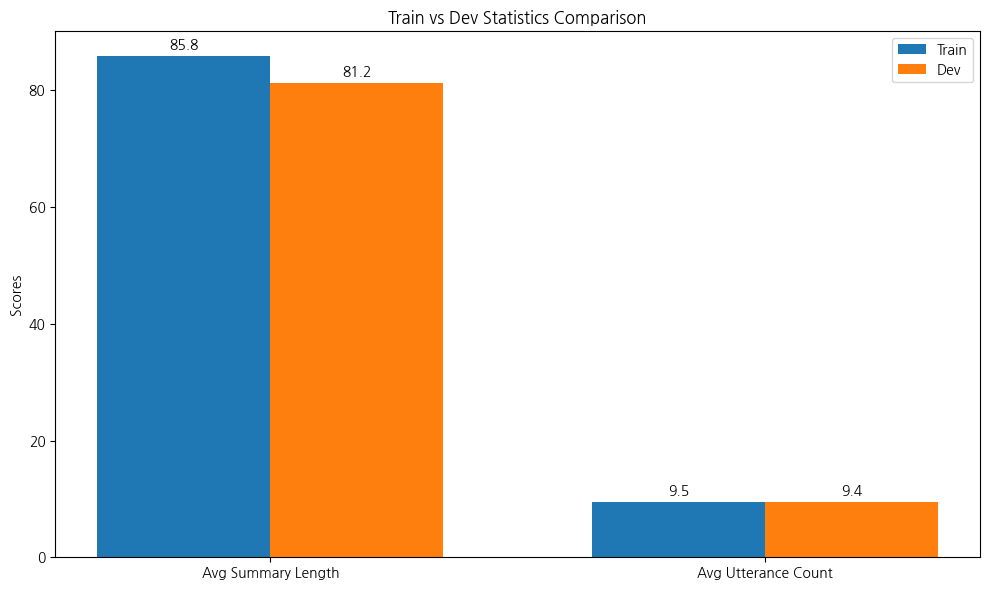

In [24]:
print("\n" + "="*70)
print(" "*20 + "데이터셋 기본 정보")
print("="*70)
print(f"Train: {len(train_raw)}개")
print(f"Dev: {len(dev_raw)}개")
print(f"Test: {len(test_raw)}개")
    
# Train 분석
train_dialogue_stats = analyze_dialogues(train_raw, "TRAIN")
train_summary_stats = analyze_summaries(train_raw, "TRAIN")
train_topic_stats = analyze_topics(train_raw, "TRAIN")
    
# Dev 분석
dev_dialogue_stats = analyze_dialogues(dev_raw, "DEV")
dev_summary_stats = analyze_summaries(dev_raw, "DEV")
dev_topic_stats = analyze_topics(dev_raw, "DEV")
    
 # Test 분석
test_dialogue_stats = analyze_dialogues(test_raw, "TEST")
    
 # 비교
train_stats = {'summary': train_summary_stats,'dialogue': train_dialogue_stats}
dev_stats = {'summary': dev_summary_stats,'dialogue': dev_dialogue_stats}
    
compare_train_dev(train_stats, dev_stats)

# 마스킹 정보 찾기

In [25]:
def find_all_special_patterns(df):
    """데이터에서 모든 #...# 패턴 찾기"""
    
    all_patterns = []
    
    # Dialogue에서 찾기
    for text in df['dialogue'].values:
        patterns = re.findall(r'#(.*?)#', text)
        all_patterns.extend(patterns)
    
    # Summary에서도 찾기 (있는 경우)
    if 'summary' in df.columns:
        for text in df['summary'].values:
            if pd.notna(text):
                patterns = re.findall(r'#(.*?)#', text)
                all_patterns.extend(patterns)
    
    return Counter(all_patterns)


def analyze_special_tokens(train_df, dev_df, test_df):
    """모든 데이터셋에서 special token 분석"""
    
    print("="*70)
    print("Special Token 분석")
    print("="*70)
    
    print("\n[Train 데이터]")
    train_patterns = find_all_special_patterns(train_df)
    print(f"총 {len(train_patterns)}개 패턴 발견")
    print("\n상위 20개:")
    for pattern, count in train_patterns.most_common(20):
        print(f"  {pattern}: {count:,}회")
    
    print("\n[Dev 데이터]")
    dev_patterns = find_all_special_patterns(dev_df)
    print(f"총 {len(dev_patterns)}개 패턴 발견")
    print("\n상위 20개:")
    for pattern, count in dev_patterns.most_common(20):
        print(f"  {pattern}: {count}회")
    
    print("\n[Test 데이터]")
    test_patterns = find_all_special_patterns(test_df)
    print(f"총 {len(test_patterns)}개 패턴 발견")
    print("\n상위 20개:")
    for pattern, count in test_patterns.most_common(20):
        print(f"  {pattern}: {count}회")
    
    # 모든 unique pattern 수집
    all_unique = set(train_patterns.keys()) | set(dev_patterns.keys()) | set(test_patterns.keys())
    
    print("\n" + "="*70)
    print(f"전체 Unique Pattern 수: {len(all_unique)}개")
    print("="*70)
    
    print("\n모든 패턴 목록:")
    for pattern in sorted(all_unique):
        train_cnt = train_patterns.get(pattern, 0)
        dev_cnt = dev_patterns.get(pattern, 0)
        test_cnt = test_patterns.get(pattern, 0)
        total = train_cnt + dev_cnt + test_cnt
        print(f"  {pattern:20s} | Train: {train_cnt:6,} | Dev: {dev_cnt:4} | Test: {test_cnt:4} | Total: {total:6,}")
    
    return all_unique


def show_masked_examples(df, pattern, n=3):
    """특정 패턴이 포함된 예시 보기"""
    
    print(f"\n{'='*70}")
    print(f"'{pattern}' 포함 예시")
    print(f"{'='*70}\n")
    
    # Dialogue에서 찾기
    matches = df[df['dialogue'].str.contains(pattern, regex=False, na=False)]
    
    if len(matches) == 0:
        print(f"'{pattern}'이 포함된 데이터가 없습니다.")
        return
    
    for idx, row in matches.head(n).iterrows():
        print(f"[예시 {idx+1}]")
        print(f"Dialogue:\n{row['dialogue']}\n")
        if 'summary' in row and pd.notna(row['summary']):
            print(f"Summary:\n{row['summary']}\n")
        print("-"*70 + "\n")

In [26]:
# 분석
all_patterns = analyze_special_tokens(train_raw, dev_raw, test_raw)
    
# Person1, Person2 외의 패턴 예시 보기
print("\n\n" + "="*70)
print("마스킹된 개인정보 예시 확인")
print("="*70)
    
# Person 제외한 패턴들
non_person_patterns = [p for p in all_patterns if not p.startswith('#Person')]
    
if non_person_patterns:
    print(f"\n발견된 개인정보 마스킹 패턴: {len(non_person_patterns)}개")
    print(non_person_patterns)
        
    # 각 패턴별 예시 1개씩
    for pattern in sorted(non_person_patterns)[:5]:  # 처음 5개만
        show_masked_examples(train_raw, pattern, n=1)
else:
    print("\nPerson 외의 마스킹 패턴이 발견되지 않았습니다.")

Special Token 분석

[Train 데이터]
총 26개 패턴 발견

상위 20개:
  Person1: 74,776회
  Person2: 68,916회
  Person3: 454회
  PhoneNumber: 230회
  Address: 93회
  Person4: 41회
  DateOfBirth: 24회
  CardNumber: 14회
  Email: 14회
  CarNumber: 8회
  Person6: 8회
  PassportNumber: 7회
  Person5: 5회
  Name: 5회
  PersonName: 5회
  Bob: 4회
  SSN: 3회
  Alex: 3회
  Kristin: 3회
  Person7: 3회

[Dev 데이터]
총 7개 패턴 발견

상위 20개:
  Person1: 2991회
  Person2: 2753회
  Person3: 7회
  PhoneNumber: 5회
  DateOfBirth: 3회
  Address: 2회
  Person4: 1회

[Test 데이터]
총 6개 패턴 발견

상위 20개:
  Person1: 2518회
  Person2: 2306회
  Person3: 15회
  PhoneNumber: 5회
  Address: 1회
  PassportNumber: 1회

전체 Unique Pattern 수: 26개

모든 패턴 목록:
  Address              | Train:     93 | Dev:    2 | Test:    1 | Total:     96
  Alex                 | Train:      3 | Dev:    0 | Test:    0 | Total:      3
  Bob                  | Train:      4 | Dev:    0 | Test:    0 | Total:      4
  Capital Airport      | Train:      2 | Dev:    0 | Test:    0 | Total:      2
  CarNumb

# 노이즈 탐지

In [27]:
def detect_noise(df, dataset_name=""):
    """노이즈 패턴 탐지"""
    
    print("="*70)
    print(f"{dataset_name} 노이즈 분석")
    print("="*70)
    
    dialogues = df['dialogue'].values
    summaries = df['summary'].values if 'summary' in df.columns else None
    
    # 1. \\n 패턴 (escaped newline)
    escaped_newline = [i for i, d in enumerate(dialogues) if '\\n' in d]
    
    # 2. <br> 태그
    br_tag = [i for i, d in enumerate(dialogues) if '<br>' in d.lower()]

    # 6. Summary의 노이즈 (있는 경우)
    summary_noise = {}
    if summaries is not None:
        summary_noise = {
            'escaped_newline': [i for i, s in enumerate(summaries) if pd.notna(s) and '\\n' in s],
            'br_tag': [i for i, s in enumerate(summaries) if pd.notna(s) and '<br>' in s.lower()],
            'multi_space': [i for i, s in enumerate(summaries) if pd.notna(s) and '  ' in s],
        }
    
    # 결과 출력
    print(f"\n[Dialogue 노이즈]")
    print(f"  \\n (escaped newline): {len(escaped_newline)}개 ({len(escaped_newline)/len(dialogues)*100:.2f}%)")
    print(f"  <br> 태그: {len(br_tag)}개 ({len(br_tag)/len(dialogues)*100:.2f}%)")
    
    if summaries is not None:
        print(f"\n[Summary 노이즈]")
        for noise_type, indices in summary_noise.items():
            print(f"  {noise_type}: {len(indices)}개 ({len(indices)/len(summaries)*100:.2f}%)")
    
    # 노이즈 예시 출력
    print(f"\n{'='*70}")
    print("노이즈 예시")
    print(f"{'='*70}")
    
    if escaped_newline:
        print(f"\n[\\n (escaped newline) 예시]")
        idx = escaped_newline[0]
        print(f"Dialogue (raw): {repr(dialogues[idx][:200])}")
        print(f"Dialogue (print): {dialogues[idx][:200]}")
    
    if br_tag:
        print(f"\n[<br> 태그 예시]")
        idx = br_tag[0]
        print(f"Dialogue: {dialogues[idx][:300]}")
    
    return {
        'escaped_newline': escaped_newline,
        'br_tag': br_tag,
        'summary_noise': summary_noise
    }

def analyze_all_noise(train_df, dev_df, test_df):
    """전체 데이터셋 노이즈 분석"""
    
    print("\n" + "="*70)
    print(" "*20 + "전체 노이즈 분석")
    print("="*70)
    
    train_noise = detect_noise(train_df, "TRAIN")
    dev_noise = detect_noise(dev_df, "DEV")
    test_noise = detect_noise(test_df, "TEST")
    
    return train_noise, dev_noise, test_noise


# 실행
if __name__ == "__main__":
    train_df = pd.read_csv('../data/train.csv')
    dev_df = pd.read_csv('../data/dev.csv')
    test_df = pd.read_csv('../data/test.csv')
    
    analyze_all_noise(train_df, dev_df, test_df)


                    전체 노이즈 분석
TRAIN 노이즈 분석

[Dialogue 노이즈]
  \n (escaped newline): 1개 (0.01%)
  <br> 태그: 1개 (0.01%)

[Summary 노이즈]
  escaped_newline: 0개 (0.00%)
  br_tag: 0개 (0.00%)
  multi_space: 0개 (0.00%)

노이즈 예시

[\n (escaped newline) 예시]
Dialogue (raw): '#Person1#: 저, 불만이 있어요. 열 분 동안 테이블에서 기다렸는데, 웨이터가 드디어 와서 주문을 받았어요. 그런데 나온 음식이 제가 주문한 게 아니더라고요.\\n#Person2#: 정말 죄송합니다. 오늘 밤은 평소보다 많이 바빠서요. 보상으로, 오늘 식사는 무료로 하겠습니다.'
Dialogue (print): #Person1#: 저, 불만이 있어요. 열 분 동안 테이블에서 기다렸는데, 웨이터가 드디어 와서 주문을 받았어요. 그런데 나온 음식이 제가 주문한 게 아니더라고요.\n#Person2#: 정말 죄송합니다. 오늘 밤은 평소보다 많이 바빠서요. 보상으로, 오늘 식사는 무료로 하겠습니다.

[<br> 태그 예시]
Dialogue: #Person1#: 요즘 잘 지내고 있어요?<br>#Person2#: 제 코치가 제 혈압을 체크해 달라고 부탁했어요.<br>#Person1#: 전에 고혈압 있다고 들은 적 있나요?<br>#Person2#: 고혈압 증상은 없어요.<br>#Person1#: 고혈압 있는 사람들은 대부분 본인이 모르는 경우가 많아요. 그래서 조용한 살인자라고 부르죠.<br>#Person2#: 고혈압 검사는 어떻게 해요?<br>#Person1#: 이 커프에 공기를 넣어서 측정할 거예요.<br>#Person2#: 측정 후에 어떤 정보를 알 수 있나요?<br>
DEV 노이즈 분석

[Dialogue 노이즈]
  \n (escaped newline): 0개 (0.00%)
  <br> 태그: 0개 

In [28]:
def find_special_chars(df, dataset_name=""):
    """#...# 패턴을 제외한 특수문자 찾기"""
    
    dialogues = df['dialogue'].values
    summaries = df['summary'].values if 'summary' in df.columns else None
    
    # #...# 패턴 제거 후 특수문자 찾기
    special_chars_dialogue = Counter()
    special_chars_summary = Counter()
    
    for text in dialogues:
        # #...# 패턴 제거
        cleaned = re.sub(r'#\w+#', '', text)
        # 특수문자 추출 (한글, 영문, 숫자, 공백, 기본 문장부호 제외)
        special = re.findall(r'[^가-힣a-zA-Z0-9\s.,!?:;()\[\]{}\'~`-]', cleaned)
        special_chars_dialogue.update(special)
    
    if summaries is not None:
        for text in summaries:
            if pd.notna(text):
                cleaned = re.sub(r'#\w+#', '', text)
                special = re.findall(r'[^가-힣a-zA-Z0-9\s.,!?:;()\[\]{}\'~`-]', cleaned)
                special_chars_summary.update(special)
    
    print(f"{'='*70}")
    print(f"{dataset_name} - #...# 외의 특수문자")
    print(f"{'='*70}\n")
    
    print(f"[Dialogue]")
    if special_chars_dialogue:
        print(f"발견된 특수문자 종류: {len(special_chars_dialogue)}개")
        for char, count in special_chars_dialogue.most_common():
            print(f"  '{char}' (ord={ord(char)}): {count:,}회")
    else:
        print("특수문자 없음")
    
    if summaries is not None:
        print(f"\n[Summary]")
        if special_chars_summary:
            print(f"발견된 특수문자 종류: {len(special_chars_summary)}개")
            for char, count in special_chars_summary.most_common():
                print(f"  '{char}' (ord={ord(char)}): {count:,}회")
        else:
            print("특수문자 없음")
    
    return special_chars_dialogue, special_chars_summary


def show_special_char_examples(df, char, n=3):
    """특정 특수문자가 포함된 예시"""
    
    print(f"\n{'='*70}")
    print(f"'{char}' 포함 예시")
    print(f"{'='*70}\n")
    
    matches = []
    for idx, row in df.iterrows():
        # #...# 제거 후에도 해당 문자가 있는지 확인
        cleaned = re.sub(r'#\w+#', '', row['dialogue'])
        if char in cleaned:
            matches.append(idx)
            if len(matches) >= n:
                break
    
    for i, idx in enumerate(matches, 1):
        print(f"[예시 {i}]")
        print(f"Dialogue: {df['dialogue'].iloc[idx]}")
        if 'summary' in df.columns:
            print(f"Summary: {df['summary'].iloc[idx]}")
        print()

In [29]:
# 실행
train_special_d, train_special_s = find_special_chars(train_raw, "TRAIN")
dev_special_d, dev_special_s = find_special_chars(dev_raw, "DEV")
test_special_d, _ = find_special_chars(test_raw, "TEST")

TRAIN - #...# 외의 특수문자

[Dialogue]
발견된 특수문자 종류: 28개
  '%' (ord=37): 440회
  '$' (ord=36): 339회
  '/' (ord=47): 92회
  '…' (ord=8230): 31회
  '&' (ord=38): 19회
  '<' (ord=60): 14회
  '>' (ord=62): 14회
  '+' (ord=43): 13회
  '—' (ord=8212): 12회
  '#' (ord=35): 6회
  '‘' (ord=8216): 5회
  '’' (ord=8217): 5회
  '\' (ord=92): 3회
  '·' (ord=183): 3회
  '@' (ord=64): 2회
  'ㅎ' (ord=12622): 2회
  'ㅠ' (ord=12640): 2회
  'É' (ord=201): 1회
  '*' (ord=42): 1회
  'é' (ord=233): 1회
  '㎡' (ord=13217): 1회
  '『' (ord=12302): 1회
  '』' (ord=12303): 1회
  '―' (ord=8213): 1회
  '成' (ord=25104): 1회
  '龍' (ord=40845): 1회
  '《' (ord=12298): 1회
  '》' (ord=12299): 1회

[Summary]
발견된 특수문자 종류: 11개
  '%' (ord=37): 105회
  '$' (ord=36): 50회
  '/' (ord=47): 30회
  '&' (ord=38): 5회
  '#' (ord=35): 4회
  '·' (ord=183): 3회
  '+' (ord=43): 2회
  '<' (ord=60): 1회
  '>' (ord=62): 1회
  '㎡' (ord=13217): 1회
  '@' (ord=64): 1회
DEV - #...# 외의 특수문자

[Dialogue]
발견된 특수문자 종류: 8개
  '$' (ord=36): 14회
  '%' (ord=37): 13회
  '‘' (ord=8216): 4회
  '’' (ord=8

In [30]:
def find_orphan_hash_rows(df, n=5):
    """#...# 패턴 제거 후 고립된 # 가 남아있는 행 추출"""
    matches = []
    for idx, row in df.iterrows():
        # #와 # 사이 모든 구절 제거 (non-greedy)
        cleaned = re.sub(r'#.*?#', '', row['dialogue'])
        if '#' in cleaned:   # 고립된 # 존재
            matches.append((idx, row['dialogue'], row.get('summary', None)))
            if len(matches) >= n:
                break
    return matches

# 사용 예시
examples = find_orphan_hash_rows(train_raw, n=5)
for idx, dialogue, summary in examples:
    print(f"[행 {idx}]")
    print("Dialogue:", dialogue)
    if summary:
        print("Summary:", summary)
    print("-"*60)

[행 3251]
Dialogue: #Person1#: 본인 소개와 지난 경험에 대해 말씀해 주세요.
#Person2#: 저는 5년 동안 임원 비서로 일했어요. 처음에는 무역 회사에서 일했고, 지금은 신탁 회사에서 일하고 있어요. 동료, 고객, 관리자, 상사들과 잘 소통하고, 도전하는 것을 좋아하며 스트레스가 많은 환경에서도 잘 일할 수 있어요.
#Person1#: 타자와 속기사 실력은 어때요?
#Person2#: 중국어는 분당 100자를 칠 수 있고, 영어 받아쓰기는 분당 150자를 할 수 있어요.
#Person1#: 컴퓨터는 잘 다루시나요?
#Person2#: 네, 잘합니다. 컴퓨터에 대해 특별한 교육도 받았고, 팩스나 복사기 같은 일반 사무기기도 잘 다뤄요.
#Person1#: 때때로 우리는 아주 바쁘고 초과근무가 필요할 수 있습니다. 그건 괜찮나요?
#Person2#: 괜찮아요. 그런데 얼마나 자주, 몇 시간 정도 초과근무해야 하는지 말씀해 주실 수 있나요?
#Person1#: 상황에 따라 달라요. 중요한 방문단이 올 때는 함께 남아야 합니다. 흔한 일입니다.
#Person2#: Mr. Smith, 한 가지 질문 드리고 싶어요.
#Person1#: 네, 물어보세요.
#Person2#: 고용된다면 구체적으로 어떤 업무를 하게 되나요?
#Person1#: 비서 업무와 크게 다르지 않아요. 하지만 저희 회사가 국제 무역을 주로 하는 회사인 만큼, 영문 서류와 영문 서신 작성은 가능한가요?
#Person2#: 물론 가능합니다. 대학에서 영어 비서학을 전공했고, 현재 업무의 주요 부분이기도 해요.
#Person1#: 기대하시는 급여는 얼마나 되나요?
#Person2#: 급여 얘기를 하기 전에 일에 대해 더 알고 싶어요. 이 포지션에 배정된 예산에 대해 말씀해 주실 수 있나요?
#Person1#: 시작 월급은 $#,000이고, 6개월 후 능력에 따라 인상될 것입니다.
#Person2#: 그 정도면 만족해요. 이 일을 정말로 하고 싶어요. 언제 최종 결정을 알 수 있

In [31]:
top_char = train_special_d.most_common(1)[0][0]
show_special_char_examples(train_raw, '#', n=3)


'#' 포함 예시

[예시 1]
Dialogue: #Person1#: 저기요! 택시 잡을 수 있을까요? 
#Person2#: 안녕하세요, 어디로 가세요? 
#Person1#: #Capital Airport#요. 
#Person2#: 비행기 출발 시간이 언제인가요? 
#Person1#: 7시 50분이에요. 
#Person2#: 그럼 7시 전까지는 도착해야겠네요. 
#Person1#: 여기서 얼마나 걸릴까요? 
#Person2#: 아, 출퇴근 시간이라 한 30분쯤 걸릴 것 같아요. 괜찮으세요? 
#Person1#: 네, 괜찮아요. 요금은 얼마인가요?
Summary: #Person1#가 #Person2#의 택시를 타고 #Capital Airport#로 가는 과정에서 소요 시간과 요금에 대해 대화합니다.

[예시 2]
Dialogue: #Person1#: 본인 소개와 지난 경험에 대해 말씀해 주세요.
#Person2#: 저는 5년 동안 임원 비서로 일했어요. 처음에는 무역 회사에서 일했고, 지금은 신탁 회사에서 일하고 있어요. 동료, 고객, 관리자, 상사들과 잘 소통하고, 도전하는 것을 좋아하며 스트레스가 많은 환경에서도 잘 일할 수 있어요.
#Person1#: 타자와 속기사 실력은 어때요?
#Person2#: 중국어는 분당 100자를 칠 수 있고, 영어 받아쓰기는 분당 150자를 할 수 있어요.
#Person1#: 컴퓨터는 잘 다루시나요?
#Person2#: 네, 잘합니다. 컴퓨터에 대해 특별한 교육도 받았고, 팩스나 복사기 같은 일반 사무기기도 잘 다뤄요.
#Person1#: 때때로 우리는 아주 바쁘고 초과근무가 필요할 수 있습니다. 그건 괜찮나요?
#Person2#: 괜찮아요. 그런데 얼마나 자주, 몇 시간 정도 초과근무해야 하는지 말씀해 주실 수 있나요?
#Person1#: 상황에 따라 달라요. 중요한 방문단이 올 때는 함께 남아야 합니다. 흔한 일입니다.
#Person2#: Mr. Smith, 한 가지 질문 드리고 싶어요.
#Person1#: 네, 물어보세

In [32]:
# 1. < > 확인
lt_gt_cases = train_df[train_df['dialogue'].str.contains('<|>', regex=True)]
print(f"'<' 또는 '>' 포함: {len(lt_gt_cases)}개\n")
for idx, row in lt_gt_cases.head(3).iterrows():
    print(f"[예시 {idx}]")
    print(row['dialogue'])
    print()

# 2. 단독 # 확인
def find_orphan_hash(text):
    # #...# 패턴 제거 후 남은 # 찾기
    cleaned = re.sub(r'#\w+#', '', text)
    return '#' in cleaned

orphan_hash = train_df[train_df['dialogue'].apply(find_orphan_hash)]
print(f"\n단독 # 포함: {len(orphan_hash)}개\n")
for idx, row in orphan_hash.head(3).iterrows():
    print(f"[예시 {idx}]")
    print(row['dialogue'])
    print()

# 3. 유니코드 따옴표 확인
unicode_quote = train_df[train_df['dialogue'].str.contains("[''']", regex=True)]

print(f"\n유니코드 따옴표 포함: {len(unicode_quote)}개\n")
for idx, row in unicode_quote.head(2).iterrows():
    print(f"[예시 {idx}]")
    print(repr(row['dialogue']))
    print()

# 4. 유니코드 말줄임표 확인
unicode_ellipsis = train_df[train_df['dialogue'].str.contains('…', regex=False)]
print(f"\n유니코드 말줄임표(…) 포함: {len(unicode_ellipsis)}개\n")
for idx, row in unicode_ellipsis.head(2).iterrows():
    print(f"[예시 {idx}]")
    print(row['dialogue'])
    print()

# 5. 외국어 문자 확인
foreign = train_df[train_df['dialogue'].str.contains('[ÉéźÈèÀàÇç]', regex=True)]
print(f"\n외국어 문자 포함: {len(foreign)}개\n")
for idx, row in foreign.iterrows():
    print(f"[예시 {idx}]")
    print(row['dialogue'])
    print()

'<' 또는 '>' 포함: 4개

[예시 76]
#Person1#: 아, 이런! 7시에 그녀를 만나기로 했는데. 지금 몇 시야?
#Person2#: 6시 30분이야.
#Person1#: 나 준비해야겠다.
#Person2#: 어디 가는데?
#Person1#: 아직 결정 못 했어. 아마도 식당에 가거나, 영화부터 볼지도 몰라.
#Person2#: 고전 영화제에서 <시민 케인> 보는 건 어때? 정말 좋다고 하더라고.
#Person1#: 아, 우리 그렇게 할까. <싸이코>도 상영 중이야. 그것도 좋다고 들었어.
#Person2#: 피 많이 나오는 공포 영화 좋아하면 좋겠지만. 나는 별로야. 이제 가 봐야겠다. 내일 수영하러 갈래?
#Person1#: 좋지, 근데 스튜디오에 가서 일해야 할지도 몰라. 아침 일찍 알려줘도 될까?
#Person2#: 물론이지. 괜찮아.
#Person1#: 아, 전화 왔다. Tracy일 거야.
#Person2#: 그럼 난 가볼게. 오늘 밤 잘 보내.
#Person1#: 고마워. 내일 얘기하자.

[예시 4406]
#Person1#: 에밀리, 이번 주말에 뭐 할 계획 있어? 나랑 앤드류는 이번 토요일에 스케이트 타러 가기로 했는데, 같이 갈래?
#Person2#: 재미있겠다. 나도 가고 싶지만, 샐리랑 이미 약속이 있어. 우리 이번 일요일에 영화 보러 가기로 했거든. 나는 토요일에 인터넷에서 영화 정보를 찾아보려고 해.
#Person1#: 좋네. 영화 제목이 뭐야?
#Person2#: <미녀와 야수>야. 엠마 왓슨이 주인공 벨 역을 맡았어. 나는 그녀를 가장 좋아하는 배우 중 하나야.
#Person1#: 나도 예전에 1991년작 <미녀와 야수> 봤어. 정말 좋았어.
#Person2#: 맞아. 사실 이 이야기는 보몽의 프랑스 동화에서 각색된 거래. 영화에 프랑스어 표현이 몇 개 들어있다는 글을 읽었어.
#Person1#: 와, 영화에 대해 많이 알고 있네. 정말 흥미롭다. 나도 보고 싶어졌어.
#Person2#: 그럼 일요일에 우리랑 같이 가서

In [33]:
RX = {
    "SPAN":     re.compile(r"#.*?#"),
    "CURRENCY": re.compile(r"([$€£¥])\s*([#\d][#\d,\.]*)"),
    "PERCENT":  re.compile(r"([#\d][#\d,\.]*)%"),
    "DATE":     re.compile(r"\b[#\d]{1,4}[./-][#\d]{1,2}[./-][#\d]{2,4}\b"),
    "TIME":     re.compile(r"\b[#\d]{1,2}:[#\d]{2}(?::[#\d]{2})?\b"),
    "NUMBER":   re.compile(r"\b[#\d][#\d,\.]*\b"),
    # 결합 패턴
    "ATTACH_POST": re.compile(r"(#\w+#)(\d+)"),   # #MASK#1234
    "ATTACH_PRE":  re.compile(r"(\d+)(#\w+#)"),   # 021#MASK#
}

def _has_hash(s: str) -> bool:
    return "#" in s

def _iter_texts(df: pd.DataFrame, cols=("dialogue","summary")):
    for col in cols:
        if col in df.columns:
            for i, t in df[col].items():
                if isinstance(t, str):
                    yield col, i, t

def eda_masked_numerics(df: pd.DataFrame, top_n_examples: int = 10):
    counts = {k: Counter() for k in
              ["SPAN","CURRENCY","PERCENT","DATE","TIME","NUMBER","ATTACHED"]}
    examples = {k: [] for k in counts}

    for col, idx, text in _iter_texts(df):
        taken = []  # (s,e)로 수집해 중복 방지

        # 0) SPAN
        for m in RX["SPAN"].finditer(text):
            counts["SPAN"]["SPAN"] += 1
            taken.append(m.span())
            if len(examples["SPAN"]) < top_n_examples:
                examples["SPAN"].append((col, idx, m.group(0)))

        # 1) 결합: #MASK#1234
        for m in RX["ATTACH_POST"].finditer(text):
            counts["ATTACHED"]["POST"] += 1
            taken.append(m.span())
            if len(examples["ATTACHED"]) < top_n_examples:
                examples["ATTACHED"].append((col, idx, m.group(0)))  # 원문
        # 2) 결합: 021#MASK#
        for m in RX["ATTACH_PRE"].finditer(text):
            counts["ATTACHED"]["PRE"] += 1
            taken.append(m.span())
            if len(examples["ATTACHED"]) < top_n_examples:
                examples["ATTACHED"].append((col, idx, m.group(0)))

        # 헬퍼: span 겹침 여부
        def _overlap(span):
            s,e = span
            return any(not (e<=ts or te<=s) for ts,te in taken)

        # 3) CURRENCY
        for m in RX["CURRENCY"].finditer(text):
            if _has_hash(m.group(2)) and not _overlap(m.span()):
                counts["CURRENCY"][m.group(1)] += 1
                taken.append(m.span())
                if len(examples["CURRENCY"]) < top_n_examples:
                    examples["CURRENCY"].append((col, idx, m.group(0)))

        # 4) PERCENT
        for m in RX["PERCENT"].finditer(text):
            if _has_hash(m.group(1)) and not _overlap(m.span()):
                counts["PERCENT"]["%"] += 1
                taken.append(m.span())
                if len(examples["PERCENT"]) < top_n_examples:
                    examples["PERCENT"].append((col, idx, m.group(0)))

        # 5) DATE
        for m in RX["DATE"].finditer(text):
            if _has_hash(m.group(0)) and not _overlap(m.span()):
                counts["DATE"]["DATE"] += 1
                taken.append(m.span())
                if len(examples["DATE"]) < top_n_examples:
                    examples["DATE"].append((col, idx, m.group(0)))

        # 6) TIME
        for m in RX["TIME"].finditer(text):
            if _has_hash(m.group(0)) and not _overlap(m.span()):
                counts["TIME"]["TIME"] += 1
                taken.append(m.span())
                if len(examples["TIME"]) < top_n_examples:
                    examples["TIME"].append((col, idx, m.group(0)))

        # 7) NUMBER (잔여)
        for m in RX["NUMBER"].finditer(text):
            if _has_hash(m.group(0)) and not _overlap(m.span()):
                counts["NUMBER"]["NUMBER"] += 1
                taken.append(m.span())
                if len(examples["NUMBER"]) < top_n_examples:
                    examples["NUMBER"].append((col, idx, m.group(0)))

    # 출력
    print("="*70)
    print("Masked numeric patterns EDA (incl. attached to #MASK#)")
    print("="*70)
    for key in ["SPAN","ATTACHED","CURRENCY","PERCENT","DATE","TIME","NUMBER"]:
        total = sum(counts[key].values())
        print(f"\n[{key}] count={total}")
        if total:
            for k,v in counts[key].most_common():
                print(f"  {k}: {v}")
            print("  Examples:")
            for col, idx, tok in examples[key]:
                print(f"   - {col}[{idx}]: {tok}")
        else:
            print("  None")
    return counts, examples

In [34]:
# 사용 예
_ = eda_masked_numerics(train_df)
_ = eda_masked_numerics(dev_df)
_ = eda_masked_numerics(test_df)

Masked numeric patterns EDA (incl. attached to #MASK#)

[SPAN] count=144624
  SPAN: 144624
  Examples:
   - dialogue[0]: #Person1#
   - dialogue[0]: #Person2#
   - dialogue[0]: #Person1#
   - dialogue[0]: #Person2#
   - dialogue[0]: #Person1#
   - dialogue[0]: #Person2#
   - dialogue[0]: #Person1#
   - dialogue[0]: #Person2#
   - dialogue[0]: #Person1#
   - dialogue[0]: #Person2#

[ATTACHED] count=4
  POST: 4
  Examples:
   - dialogue[9660]: #PhoneNumber#25395
   - dialogue[9660]: #PhoneNumber#60745
   - dialogue[9660]: #PhoneNumber#58968
   - dialogue[9660]: #PhoneNumber#81663

[CURRENCY] count=1
  $: 1
  Examples:
   - dialogue[3251]: $#,000

[PERCENT] count=0
  None

[DATE] count=0
  None

[TIME] count=0
  None

[NUMBER] count=0
  None
Masked numeric patterns EDA (incl. attached to #MASK#)

[SPAN] count=5762
  SPAN: 5762
  Examples:
   - dialogue[0]: #Person1#
   - dialogue[0]: #Person2#
   - dialogue[0]: #Person1#
   - dialogue[0]: #Person2#
   - dialogue[0]: #Person1#
   - dialogu

# 노이즈 잘 전처리되었는지 확인

In [35]:
train_denoised = pd.read_csv("../data/clean/denoise/train.csv")
train_denoised.head()

,fname,dialogue,summary,topic
0,train_0,"#Person1#: 안녕하세요, Mr. Smith. 저는 Dr. Hawkins입니다. 오늘 무슨 일로 오셨어요? \n#Person2#: 건강검진을 받으려고 왔어요. \n#Person1#: 네, 5년 동안 검진을 안 받으셨네요. 매년 한 번씩 받으셔야 해요. \n#Person2#: 알죠. 특별히 아픈 데가 없으면 굳이 갈 필요가 없다고 생각했어요. \n#Person1#: 음, 심각한 질병을 피하려면 미리 발견하는 게 제일 좋거든요. 본인을 위해서라도 매년 한 번은 오세요. \n#Person2#: 알겠습니다. \n#Person1#: 여기 좀 볼까요. 눈과 귀는 괜찮으시네요. 깊게 숨 한 번 쉬어보세요. Mr. Smith, 담배 피우세요? \n#Person2#: 네. \n#Person1#: 담배가 폐암하고 심장병의 주된 원인인 거 아시죠? 끊으셔야 해요. \n#Person2#: 수백 번 시도했는데, 도저히 습관이 안 끊어져요. \n#Person1#: 음, 도움 될만한 수업과 약물들이 있습니다. 가시기 전에 더 정보를 드릴게요. \n#Person2#: 네, 고맙습니다, 의사 선생님.","Mr. Smith는 Dr. Hawkins에게 건강검진을 받으러 와서, 매년 검진 필요성을 안내받고 흡연 습관 개선을 위한 도움을 제안받았습니다.",건강검진
1,train_1,"#Person1#: 안녕하세요, Mrs. Parker. 잘 지내셨나요?\n#Person2#: 안녕하세요, Dr. Peters. 잘 지내고 있어요. Ricky랑 저희 둘 다 백신 맞으러 왔어요.\n#Person1#: 알겠습니다. 백신 기록을 보니 Ricky는 소아마비, 파상풍, 그리고 B형 간염 예방접종을 받았네요. 지금 14개월이라 A형 간염, 수두, 홍역 예방접종을 맞아야 해요.\n#Person2#: 풍진과 유행성이하선염은요?\n#Person1#: 지금은 이 정도만 맞고, 몇 주 후에 나머지를 할 수 있어요.\n#Person2#: 좋아요. 그리고 저도 파상풍 부스터가 필요할 것 같아요. 마지막으로 맞은 지 아마 15년은 된 것 같아요!\n#Person1#: 기록을 확인해서 간호사에게 부스터도 맞출 수 있도록 할게요. 이제 Ricky 팔 꽉 잡아주세요, 좀 따끔할 수 있어요.","Mrs. Parker가 Ricky와 함께 백신 접종을 위해 방문하였고, Dr. Peters는 Ricky에게 적절한 백신을 접종하도록 안내합니다.",백신 접종
2,train_2,"#Person1#: 저기요, 열쇠 세트 본 적 있어요?\n#Person2#: 어떤 종류의 열쇠요?\n#Person1#: 열쇠 다섯 개랑 작은 발 장식이 달려 있어요.\n#Person2#: 아, 안타깝네요! 못 봤어요.\n#Person1#: 그럼, 같이 좀 찾아주실 수 있어요? 여긴 처음이라서요.\n#Person2#: 물론이죠. 도와드릴게요.\n#Person1#: 정말 친절하시네요.\n#Person2#: 별거 아니에요. 이봐요, 찾았어요.\n#Person1#: 아, 감사합니다! 어떻게 감사해야 할지 모르겠네요.\n#Person2#: 천만에요.",#Person1#은 열쇠 세트를 잃어버리고 #Person2#에게 찾는 것을 도와달라고 요청합니다.,열쇠 분실
3,train_3,"#Person1#: 너 여자친구 있는 거 왜 말 안 했어?\n#Person2#: 미안해, 네가 알고 있는 줄 알았어.\n#Person1#: 그런데 사랑하는 사람 있다고 말했어야지.\n#Person2#: 내가 안 했었나?\n#Person1#: 안 했잖아.\n#Person2#: 이제 말하잖아.\n#Person1#: 맞아, 그런데 이전에 말할 수도 있었잖아.\n#Person2#: 네가 관심 없을 줄 알았어.\n#Person1#: 진심이야? 결혼할 거라는 말도 안 하다니 참.\n#Person2#: 미안해, 별로 중요하지 않다고 생각했어.\n#Person1#: 아, 남자들 다 똑같아!",#Person1#은 #Person2#가 여자친구가 있고 결혼할 예정이라는 사실을 말하지 않아서 화가 났습니다.,여자친구와의 결혼
4,train_4,"#Person1#: 안녕, 오늘 너무 멋져 보이네요. 저랑 춤 한 곡 추실래요?\n#Person2#: 고맙네요! 그런데 저는 춤 잘 못 춰요...\n#Person1#: 괜찮아요. 제가 멋진 춤 동작 알려드릴게요. 제 이름은 Malik이에요.\n#Person2#: 만나서 반가워요. 저는 Wen이고, 이 친구는 Nikki예요.\n#Person1#: 기분 어때요? 친구랑 같이 춤춰도 될까요?\n#Person2#: 괜찮아요, 대신 제 발을 밟아도 괜찮으시다면요.\n#Person1#: 알겠어요. 좋아요! 가요!","Malik은 Wen과 Nikki에게 춤을 제안하고, Wen은 발을 밟는 것을 감수하면 괜찮다고 응답합니다.",춤 제안


In [36]:
dev_denoised = pd.read_csv("../data/clean/denoise/dev.csv")
dev_denoised.head()

,fname,dialogue,summary,topic
0,dev_0,"#Person1#: 안녕하세요, 오늘 기분이 어떠세요?\n#Person2#: 요즘 숨쉬기가 힘들어요.\n#Person1#: 최근에 감기에 걸렸나요?\n#Person2#: 아니요, 감기는 안 걸렸어요. 숨쉴 때 가슴이 답답해요.\n#Person1#: 혹시 알고 있는 알레르기 있으세요?\n#Person2#: 아니요, 특별히 알고 있는 알레르기는 없어요.\n#Person1#: 이게 항상 그런가요, 아니면 주로 활동할 때 그런가요?\n#Person2#: 운동할 때 특히 많이 그래요.\n#Person1#: 천식 검사를 위해 폐 전문의에게 가보시는 게 좋겠어요.\n#Person2#: 도와주셔서 감사합니다, 의사 선생님.","#Person2#는 숨쉬기 어려워합니다. 의사는 #Person2#에게 증상을 확인하고, 천식 검사를 위해 폐 전문의에게 가볼 것을 권합니다.",의사 상담
1,dev_1,"#Person1#: 야 Jimmy, 오늘 좀 이따 운동하러 가자.\n#Person2#: 그래, 몇 시에 갈래?\n#Person1#: 3시 30분 어때?\n#Person2#: 좋아. 오늘은 다리랑 팔 운동하는 날이야.\n#Person1#: 근데 나 아까 농구해서 다리가 좀 아파. 오늘은 팔이랑 복근 운동하자.\n#Person2#: 나 주간 일정이 있어. 너 때문에 다 엉망이야.\n#Person1#: 아, 두 날짜만 바꾸면 되잖아. 다리는 금요일에 하면 돼.\n#Person2#: 알았어. 그럼 3시 30분에 체육관에서 보자.",#Person1#는 Jimmy를 운동하러 초대하고 팔과 복근 운동을 하도록 설득합니다.,운동 계획
2,dev_2,"#Person1#: 나 진짜 건강에 안 좋은 음식 좀 그만 먹어야겠어. \n#Person2#: 맞아, 무슨 말인지 알아. 나도 요즘 건강하게 먹으려고 하거든. \n#Person1#: 요즘은 뭐 먹어? \n#Person2#: 주로 과일이랑 채소, 닭고기 먹지. \n#Person1#: 그게 다야? \n#Person2#: 거의 그렇지 뭐. \n#Person1#: 왜 다른 건 안 먹어? \n#Person2#: 음, 과일이랑 채소는 진짜 건강에 좋잖아. \n#Person1#: 그럼 닭고기는? \n#Person2#: 구워 먹으면 정말 건강에 좋아. \n#Person1#: 그래, 그게 훨씬 건강해 보이네.","#Person1#은 건강에 안 좋은 음식을 그만 먹기로 결심하고, #Person2#는 자신의 건강한 식단을 #Person1#에게 공유합니다.",건강한 식단
3,dev_3,"#Person1#: 너 UFO 믿어?\n#Person2#: 당연하지, 있는 거 아냐.\n#Person1#: 근데 나는 못 봤어.\n#Person2#: 바보야? 그게 UFO라서 아무나 볼 수 있는 게 아니야.\n#Person1#: 너는 볼 수 있다는 거야?\n#Person2#: 맞아. 꿈에서 볼 수 있어.\n#Person1#: 지구로 오는 거야?\n#Person2#: 아니야. 자기네 우주에서 외계인을 지구로 보내는 게 임무야.\n#Person1#: 우주에서 온 외계인? 말해봤어? 어떻게 생겼어?\n#Person2#: 아이고, 아이고, 하나씩 물어봐! 로봇같이 생겼는데 말할 수 있어. 인간이랑 친구가 되는 게 임무야.\n#Person1#: 그러면 너 걔들이랑 얘기해? 무슨 언어로?\n#Person2#: 당연히 영어로 하지, 걔네도 화성에서 영어 배워.\n#Person1#: 와, 대단하다!","#Person2#는 UFO를 믿고 꿈에서 볼 수 있다고 한다. #Person1#은 #Person2#가 꿈에서 본 UFO와 외계인에 대해 물어보고, #Person2#의 꿈이 대단하다고 생각한다.",UFO와 외계인
4,dev_4,"#Person1#: 오늘 학교 갔어?\n#Person2#: 당연히 갔지. 너는?\n#Person1#: 가기 싫어서 안 갔어.\n#Person2#: 아쉽네. 근데 영화 본 지는 얼마 안 됐어?\n#Person1#: 화제를 바꾸네.\n#Person2#: 진지하게 묻는 거야, 본 적 있어?\n#Person1#: 아니, 안 봤어. 왜?\n#Person2#: 이번 주말에 정말 영화 보러 가고 싶거든.\n#Person1#: 그럼 가.\n#Person2#: 혼자 가기는 좀 싫어.\n#Person1#: 아무튼, 내일은 학교 갈 거야?\n#Person2#: 아니, 내일은 영화 보러 갈까 생각 중이야.","#Person1#은 오늘 학교에 가지 않았고, #Person2#는 내일 학교 대신 영화관에 가고 싶어합니다.",학교와 주말 계획


In [37]:
test_denoised = pd.read_csv("../data/clean/denoise/test.csv")
test_denoised.head()

,fname,dialogue
0,test_0,"#Person1#: Ms. Dawson, 받아쓰기 좀 부탁드려야겠어요. \n#Person2#: 네, 말씀하세요... \n#Person1#: 이걸 오늘 오후까지 모든 직원들에게 사내 메모로 보내야 해요. 준비됐나요? \n#Person2#: 네, 말씀하세요. \n#Person1#: 모든 직원에게 알립니다... 즉시 발효되어 모든 사내 통신은 이메일과 공식 메모로만 제한됩니다. 근무 시간 동안 즉시 메시지 프로그램 사용은 금지됩니다. \n#Person2#: 이 정책이 사내 통신에만 적용되나요, 아니면 외부 통신에도 해당되나요? \n#Person1#: 이는 모든 통신에 적용됩니다. 사무실 내 직원 간 통신 뿐만 아니라 외부 통신도 해당됩니다. \n#Person2#: 하지만 많은 직원들이 고객과 소통하려고 즉시 메시지를 사용합니다. \n#Person1#: 통신 방법을 바꿔야 할 것입니다. 이 사무실에서는 즉시 메시지를 사용하는 것을 원하지 않습니다. 너무 많은 시간이 낭비됩니다! 이제 계속해서 메모를 작성해 주세요. 어디까지 했죠? \n#Person2#: 내외부 통신에 적용됩니다. \n#Person1#: 네. 즉시 메시지를 계속 사용하면 경고 후 시정 조치가 이루어지며, 두 번째 위반 시 해고될 수 있습니다. 이번 정책에 관한 질문은 부서장에게 문의하세요. \n#Person2#: 그게 다인가요? \n#Person1#: 네. 오늘 오후 4시까지 이 메모를 작성하고 배포해주세요."
1,test_1,"#Person1#: 드디어 왔네! 뭐가 이렇게 오래 걸렸어?\n#Person2#: 차가 또 막혔어. Carrefour 교차로 근처에서 교통체증이 엄청 심했거든.\n#Person1#: 거긴 출퇴근 시간에 항상 혼잡하잖아. 집에 갈 때 다른 길 좀 찾아보는 게 어때?\n#Person2#: 솔직히 피할 수 있을 것 같진 않아.\n#Person1#: 대중교통으로 출퇴근하는 게 더 나을 수도 있겠다.\n#Person2#: 생각해봐야 할 것 같아. 대중교통이 꽤 괜찮더라고.\n#Person1#: 환경에도 더 좋을 거야.\n#Person2#: 알아. 내 차가 이 도시의 오염 문제를 얼마나 악화시키는지 미안하게 생각해.\n#Person1#: 지하철 타고 다니는 게 운전하는 것보다 스트레스도 덜할 거야.\n#Person2#: 문제는 차가 줄 수 있는 자유를 정말 그리워할 것 같단 말이지.\n#Person1#: 글쎄, 날씨 좋으면 자전거로 출근해봐. 차만큼 자유로울 거야.\n#Person2#: 맞아. 운동도 될 것 같아!\n#Person1#: 그럼 출근할 때 차 안 타기로 했어?\n#Person2#: 응, 나나 환경에 좋지 않잖아."
2,test_2,"#Person1#: Kate, 여기서 일어난 일을 믿기 힘들 거야.\n#Person2#: 무슨 일이야?\n#Person1#: Masha랑 Hero가 이혼한대.\n#Person2#: 설마, 무슨 일 있었던 거야?\n#Person1#: 글쎄, 자세히는 모르겠는데 두 달 동안 별거 중이더니 결국 이혼 신청을 했대.\n#Person2#: 정말 놀랍네. 난 둘이 정말 잘 어울리는 커플이라 생각했어. 아이들은 어떻게 되는 거야? 누가 양육권을 가지지?\n#Person1#: Masha가 양육권을 가지기로 했대. 모든 게 조용하고 원만하게 진행되고 있고, 집이나 주식 문제는 깔끔하게 해결됐다고 하더라.\n#Person2#: 보통 듣는 사건들이랑 달리 잘 진행되네. 그래도 믿기지가 않네, Masha랑 Hero, 완벽한 커플이었는데. 언제쯤 이혼이 확정될까?\n#Person1#: 아마도 새해 초쯤이겠지."
3,test_3,"#Person1#: 생일 축하해, 이거 너를 위한 선물이야, Brian.\n#Person2#: 기억해줘서 정말 고마워. 들어와서 파티를 즐겨. 모두들 와 있어서 정말 좋은 시간이 될 거야.\n#Person1#: Brian, 너랑 춤춰도 될까?\n#Person2#: 그래, 좋아.\n#Person1#: 정말 멋진 파티야.\n#Person2#: 응, 너는 항상 모두에게 인기가 많아. 그리고 오늘 정말 예뻐 보여.\n#Person1#: 고마워, 그렇게 말해줘서 다정하네. 목걸이가 드레스랑 잘 어울려서 나도 그렇게 느껴져.\n#Person2#: 정말 멋있어 보여, 너 정말 빛나고 있어.\n#Person1#: 고마워, 정말 멋진 파티야. 네 생일을 축하하기 위해 같이 한 잔 해야겠다."
4,test_4,"#Person1#: 이 올림픽 공원 정말 크다! \n#Person2#: 맞아. 지금 우리는 이 공원의 중심인 올림픽 스타디움에 있어. \n#Person1#: 멋지다! 언제 완공될까? \n#Person2#: 전체 스타디움은 이번 6월에 완공될 예정이야. \n#Person1#: 좌석이 얼마나 되지? \n#Person2#: 음, 총 5000석이 있어. \n#Person1#: 이렇게 클 줄은 몰랐어! \n#Person2#: 그치? 저기 봐, 저게 육상 트랙이야. 그리고 저쪽이 점프 구간이야. \n#Person1#: 아... 알겠어. 이봐, 여기 표지판에 봐, 등산 금지라고 하네. \n#Person2#: 외국인 방문객들을 위해 영어 번역된 표지판도 많이 붙였어."


In [38]:
# 분석
all_patterns = analyze_special_tokens(train_denoised, dev_denoised, test_denoised)
    
# Person1, Person2 외의 패턴 예시 보기
print("\n\n" + "="*70)
print("마스킹된 개인정보 예시 확인")
print("="*70)
    
# Person 제외한 패턴들
non_person_patterns = [p for p in all_patterns if not p.startswith('#Person')]
    
if non_person_patterns:
    print(f"\n발견된 개인정보 마스킹 패턴: {len(non_person_patterns)}개")
    print(non_person_patterns)
        
    # 각 패턴별 예시 1개씩
    for pattern in sorted(non_person_patterns)[:5]:  # 처음 5개만
        show_masked_examples(train_raw, pattern, n=1)
else:
    print("\nPerson 외의 마스킹 패턴이 발견되지 않았습니다.")

Special Token 분석

[Train 데이터]
총 20개 패턴 발견

상위 20개:
  Person1: 74,776회
  Person2: 68,916회
  Person3: 454회
  PhoneNumber: 230회
  Address: 93회
  Person4: 41회
  DateOfBirth: 24회
  CardNumber: 14회
  Email: 14회
  CarNumber: 8회
  Person6: 8회
  PassportNumber: 7회
  Person5: 5회
  Name: 5회
  PersonName: 5회
  SSN: 3회
  Person7: 3회
  Amount: 1회
  Price: 1회
  FlightNumber: 1회

[Dev 데이터]
총 7개 패턴 발견

상위 20개:
  Person1: 2991회
  Person2: 2753회
  Person3: 7회
  PhoneNumber: 5회
  DateOfBirth: 3회
  Address: 2회
  Person4: 1회

[Test 데이터]
총 6개 패턴 발견

상위 20개:
  Person1: 2518회
  Person2: 2306회
  Person3: 15회
  PhoneNumber: 5회
  Address: 1회
  PassportNumber: 1회

전체 Unique Pattern 수: 20개

모든 패턴 목록:
  Address              | Train:     93 | Dev:    2 | Test:    1 | Total:     96
  Amount               | Train:      1 | Dev:    0 | Test:    0 | Total:      1
  CarNumber            | Train:      8 | Dev:    0 | Test:    0 | Total:      8
  CardNumber           | Train:     14 | Dev:    0 | Test:    0 | Total:     14


In [39]:
# 실행
train_special_d, train_special_s = find_special_chars(train_denoised, "TRAIN")
dev_special_d, dev_special_s = find_special_chars(dev_denoised, "DEV")
test_special_d, _ = find_special_chars(test_denoised, "TEST")

TRAIN - #...# 외의 특수문자

[Dialogue]
발견된 특수문자 종류: 9개
  '%' (ord=37): 440회
  '$' (ord=36): 338회
  '/' (ord=47): 94회
  '&' (ord=38): 19회
  '+' (ord=43): 13회
  '@' (ord=64): 2회
  'É' (ord=201): 1회
  'é' (ord=233): 1회
  '㎡' (ord=13217): 1회

[Summary]
발견된 특수문자 종류: 7개
  '%' (ord=37): 105회
  '$' (ord=36): 50회
  '/' (ord=47): 30회
  '&' (ord=38): 5회
  '+' (ord=43): 2회
  '㎡' (ord=13217): 1회
  '@' (ord=64): 1회
DEV - #...# 외의 특수문자

[Dialogue]
발견된 특수문자 종류: 5개
  '$' (ord=36): 14회
  '%' (ord=37): 13회
  '&' (ord=38): 1회
  'ź' (ord=378): 1회
  '/' (ord=47): 1회

[Summary]
발견된 특수문자 종류: 2개
  '%' (ord=37): 3회
  '$' (ord=36): 3회
TEST - #...# 외의 특수문자

[Dialogue]
발견된 특수문자 종류: 5개
  '$' (ord=36): 17회
  '%' (ord=37): 12회
  '+' (ord=43): 2회
  '/' (ord=47): 2회
  '&' (ord=38): 1회


# 오탈자 수정 잘 되었는지 확인

In [40]:
# hanspell 의 설치 참고
# https://cherie-ssom.tistory.com/2

import hanspell
print(hanspell.__file__)

/home/jwk14/miniforge3/envs/nlp-competition/lib/python3.10/site-packages/hanspell/__init__.py


In [ ]:
import pandas as pd

# raw(원본) / denoised / typo_fix 데이터 불러오기
train_denoised = pd.read_csv("../data/clean/denoise/train.csv")
train_typo_fix = pd.read_csv("../data/clean/typo_fix/train.csv")

dev_denoised = pd.read_csv("../data/clean/denoise/dev.csv")
dev_typo_fix = pd.read_csv("../data/clean/typo_fix/dev.csv")

test_denoised = pd.read_csv("../data/clean/denoise/test.csv")
test_typo_fix = pd.read_csv("../data/clean/typo_fix/test.csv")

In [ ]:
import difflib
from IPython.display import display, HTML

def compare_and_display_all_diffs(df_raw, df_denoised, df_typo_fix, dataset_name=""):
    """
    세 개의 데이터프레임을 순회하며 raw->denoised, denoised->typo_fix 간의
    차이점이 있는 모든 항목을 찾아 HTML로 시각화합니다.
    """
    print(f"====== {dataset_name} 데이터셋 전체 비교 시작 ======")
    
    # diff 객체 생성
    diff = difflib.HtmlDiff(wrapcolumn=80)
    
    # 모든 인덱스를 순회
    for idx in df_raw.index:
        # 각 버전의 텍스트 가져오기
        raw_text = df_raw.loc[idx, 'dialogue']
        denoised_text = df_denoised.loc[idx, 'dialogue']
        typo_fix_text = df_typo_fix.loc[idx, 'dialogue']
        
        # 변경점이 하나라도 있는지 확인하기 위한 플래그
        has_change = False
        
        # 1. raw -> denoised 비교
        if raw_text != denoised_text:
            if not has_change:
                print(f"\n------ [Index: {idx}] 변경 내역 ------")
                has_change = True
            
            print(f"----- Raw vs Denoised -----")
            html_diff1 = diff.make_file(raw_text.splitlines(), denoised_text.splitlines(), 
                                      fromdesc='Raw', todesc='Denoised')
            display(HTML(html_diff1))

        # 2. denoised -> typo_fix 비교
        if denoised_text != typo_fix_text:
            if not has_change:
                print(f"\n------ [Index: {idx}] 변경 내역 ------")
                has_change = True

            print(f"----- Denoised vs Typo_Fix -----")
            html_diff2 = diff.make_file(denoised_text.splitlines(), typo_fix_text.splitlines(),
                                      fromdesc='Denoised', todesc='Typo_Fix')
            display(HTML(html_diff2))
            
    print(f"\n====== {dataset_name} 데이터셋 비교 완료 ======")

In [ ]:
compare_and_display_all_diffs(train_raw, train_denoised, train_typo_fix, "Train")

In [ ]:
compare_and_display_all_diffs(dev_raw, dev_denoised, dev_typo_fix, "Dev")

In [ ]:
compare_and_display_all_diffs(test_raw, test_denoised, test_typo_fix, "Test")